In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
teacher_model_training_data = pd.read_csv('Data/teacher_training_ab_wind.csv', encoding = "ISO-8859-1")
teacher_model_training_data = teacher_model_training_data.sample(frac=0.5)

In [4]:
teacher_model_test_data = pd.read_csv('Data/teacher_test_ab_wind.csv', encoding = "ISO-8859-1")

In [5]:
teacher_model_training_data.head(1)

longitude  latitude                name       id              date  \
928718    -111.45     52.07  CORONATION CLIMATE  3011887  2020-06-09 23:00   

        temp  precip  wind_direction  wind_speed  
928718   8.1     0.0            16.0         7.0

In [5]:
#teacher_model_testing_data = pd.read_csv('Data/teacher_test_ab_wind.csv', encoding = "ISO-8859-1")

In [6]:
#teacher_model_data = data.groupby('date').sample(frac=0.8, random_state = 123)

In [7]:
#teacher_model_data.to_csv('Data/teacher_ab_wind.csv', sep = ',', index = False)

In [8]:
#student_model_data = data[~data.index.isin(teacher_model_data.index)]

In [9]:
#student_model_data
#student_model_data.to_csv('Data/student_ab_wind.csv', sep = ',', index = False)

In [10]:
#teacher_model_training_data = teacher_model_data.groupby('date').sample(frac=0.7, random_state = 321)

In [11]:
#teacher_model_test_data = teacher_model_data[~teacher_model_data.index.isin(teacher_model_training_data.index)]

In [12]:
# teacher_model_training_data.to_csv('Data/teacher_training_ab_wind.csv', sep = ',', index = False)
# teacher_model_test_data.to_csv('Data/teacher_test_ab_wind.csv', sep = ',', index = False)

In [6]:
teacher_model_training_data['name'].unique() # 39 total

array(['CORONATION CLIMATE', 'CLARESHOLM', 'MILK RIVER',
       'FORT MCMURRAY A', 'RED EARTH', 'SUNDRE A', 'MEDICINE HAT',
       'EDSON', 'LETHBRIDGE', 'EDMONTON STONY PLAIN CS', 'LACOMBE CDA 2',
       'FORT CHIPEWYAN RCS', 'BANFF CS', "CALGARY INT'L CS", 'BOW VALLEY',
       'EDMONTON INTERNATIONAL CS', 'FORT CHIPEWYAN', 'DRUMHELLER EAST',
       'SLAVE LAKE', 'STRATHMORE AGDM', 'PINCHER CREEK CLIMATE',
       'EDSON CLIMATE', 'LETHBRIDGE CDA', 'BROOKS', 'LLOYDMINSTER',
       'VEGREVILLE', 'MEDICINE HAT RCS', 'ROCKY MTN HOUSE (AUT)',
       'HIGH LEVEL', 'EDMONTON BLATCHFORD', 'JASPER WARDEN',
       'ONEFOUR CDA', 'HIGH LEVEL A', 'CAMROSE', 'RED DEER REGIONAL A',
       'SLAVE LAKE RCS', 'FORT MCMURRAY CS', 'WHITECOURT A', 'WHITECOURT'],
      dtype=object)

Text(0.5, 0, 'Wind speed')

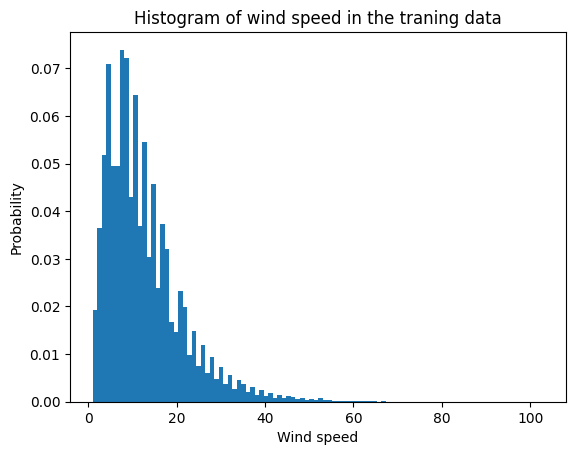

In [7]:
plt.hist(teacher_model_training_data['wind_speed'], bins=100, density=True)
plt.title("Histogram of wind speed in the traning data")
plt.ylabel("Probability")
plt.xlabel("Wind speed")

In [13]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [56]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    # Fcm hyperparameters
    FCM_Nc = 10
    FCM_m = 2
    tol = 1e-5
    max_iter = 100

    
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break

    # 模型训练
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
#     plt.plot(train_y, y_hat_train, 'ro', alpha=.2)
    
# #     plt.scatter(range(len(train_y)), train_y, c='blue', label='Target')
# #     plt.scatter(range(len(y_hat_train)), y_hat_train, c='red', label='Predict')
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
#     plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
# #     plt.scatter(range(len(test_y)), test_y, c='blue', label='Target')
# #     plt.scatter(range(len(y_hat_test)), y_hat_test, c='red', label='Predict')
#     plt.title('Testing')
#     plt.legend()
#     plt.show()
    plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
    plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
    plt.title('FCM prediction vs true value for testing data')
    plt.legend()


    return rmse_train, rmse_validation


In [15]:
def linear_model(train_x, train_y, validation_x, validation_y):
    reg = LinearRegression().fit(train_x, train_y)
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False)

In [16]:
def build_neural_network_model():
    model = models.Sequential()
    
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1))    
    
    return model

In [55]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error'])), neural_network_model

In [54]:
# hyperparameters for the expeirment
number_of_neighbour_stations = [1,2,3,4,5,6] # 2 is optimal
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 10
# General hyperparameter
max_threshold_distance = 200 #km
min_threshold_distance = 2 #km

# Results containers
training_results = []
validation_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):
    kf = KFold(n_splits=number_of_folds, shuffle=True)
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # First fitler the data based on the settings
        train_x = []
        train_y = []
        
        for station in teacher_model_training_data['name'].unique():
            features, target = Data_utils.generate_data(
                teacher_model_training_data, 
                station, 
                hyperparameter_value, 
                max_threshold_distance, 
                min_threshold_distance
            )
    
            if (len(features)!=0) & (len(target)!=0):
                np_features = np.array(features)
                np_target = np.array(target)

                train_x.append(np_features)
                train_y.append(np_target)
                
        # After all stations are filtered, flatten the data into a huge list        
        flatten_x =  np.array([data for sublist in train_x for data in sublist])
        flatten_y =  np.array([data for sublist in train_y for data in sublist])
        
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        validation_results_fold = []
        test_results_fold = []
        nn_history_fold = []
        
        for i, (train_index, val_index) in enumerate(kf.split(flatten_x)):
            split_train_x = flatten_x[train_index]
            split_train_y = flatten_y[train_index]

            split_val_x = flatten_x[val_index]
            split_val_y = flatten_y[val_index]
            # Normalize the input
            split_train_x, split_val_x = preprocess_data(split_train_x, split_val_x)            
            # Linear model
            li_train_rmse, li_val_rmse = linear_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            validation_results_fold.append({'linear_val' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            validation_results_fold.append({'fcm_val' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse, _ = neural_network_model(split_train_x, split_train_y, split_val_x , split_val_y)
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            validation_results_fold.append({'nn_val' : nn_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        validation_results.append(validation_results_fold)
        nn_histories.append(nn_history_fold)
        
        

target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 1
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 1
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 1
target HIGH LEVEL has neightbour_stations 0 not match number_of_neighbours 1
target HIGH LEVEL A has neightbour_stations 0 not match number_of_neighbours 1
target FORT MCMURRAY CS has neightbour_stations 0 not match number_of_neighbours 1


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.700927612737708
linear_validation
7.252793776053193
FCM traning RMSE: 6.504994835101076


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.723743812004997


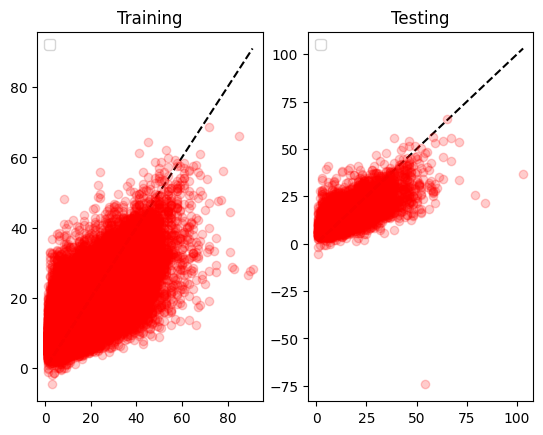

Epoch 1/50
3098/3098 [==============================] - 5s 2ms/step - loss: 73.3630 - root_mean_squared_error: 8.5652 - val_loss: 52.4534 - val_root_mean_squared_error: 7.2425
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 48.4762 - root_mean_squared_error: 6.9625 - val_loss: 49.9216 - val_root_mean_squared_error: 7.0655
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 46.7413 - root_mean_squared_error: 6.8368 - val_loss: 48.0631 - val_root_mean_squared_error: 6.9328
Epoch 4/50
3098/3098 [==============================] - 5s 1ms/step - loss: 45.6740 - root_mean_squared_error: 6.7583 - val_loss: 46.8505 - val_root_mean_squared_error: 6.8447
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.8116 - root_mean_squared_error: 6.6941 - val_loss: 46.4997 - val_root_mean_squared_error: 6.8191
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.3916 - root_mean_squared_error: 6.6627 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 41.0441 - root_mean_squared_error: 6.4066 - val_loss: 42.9107 - val_root_mean_squared_error: 6.5506
Epoch 48/50
3098/3098 [==============================] - 5s 1ms/step - loss: 41.0077 - root_mean_squared_error: 6.4037 - val_loss: 43.0166 - val_root_mean_squared_error: 6.5587
Epoch 49/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.9751 - root_mean_squared_error: 6.4012 - val_loss: 42.9542 - val_root_mean_squared_error: 6.5539
Epoch 50/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.9435 - root_mean_squared_error: 6.3987 - val_loss: 42.7968 - val_root_mean_squared_error: 6.5419


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.714233708158953
linear_validation
6.664847689997698
FCM traning RMSE: 6.517728331267349


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.471680624761969


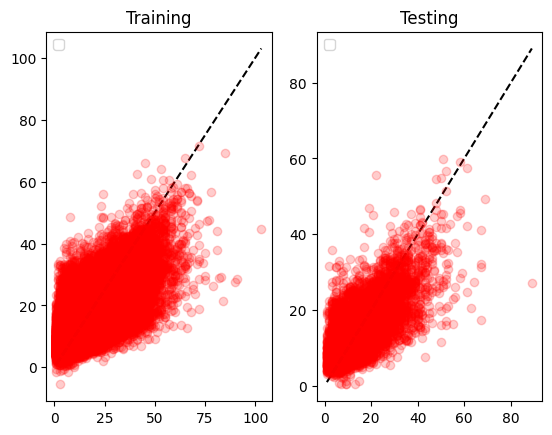

Epoch 1/50
3098/3098 [==============================] - 5s 1ms/step - loss: 72.1816 - root_mean_squared_error: 8.4960 - val_loss: 47.4232 - val_root_mean_squared_error: 6.8865
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 48.0593 - root_mean_squared_error: 6.9325 - val_loss: 44.5103 - val_root_mean_squared_error: 6.6716
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 46.2005 - root_mean_squared_error: 6.7971 - val_loss: 43.4648 - val_root_mean_squared_error: 6.5928
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.2980 - root_mean_squared_error: 6.7304 - val_loss: 42.9622 - val_root_mean_squared_error: 6.5546
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.5817 - root_mean_squared_error: 6.6770 - val_loss: 42.5695 - val_root_mean_squared_error: 6.5245
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.1611 - root_mean_squared_error: 6.6454 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 40.8624 - root_mean_squared_error: 6.3924 - val_loss: 40.1863 - val_root_mean_squared_error: 6.3393
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.8794 - root_mean_squared_error: 6.3937 - val_loss: 39.8741 - val_root_mean_squared_error: 6.3146
Epoch 49/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.8274 - root_mean_squared_error: 6.3896 - val_loss: 39.9821 - val_root_mean_squared_error: 6.3231
Epoch 50/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.8289 - root_mean_squared_error: 6.3898 - val_loss: 40.0321 - val_root_mean_squared_error: 6.3271


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.704168197114038
linear_validation
6.756286092232229
FCM traning RMSE: 6.488666251244116


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.624269606924375


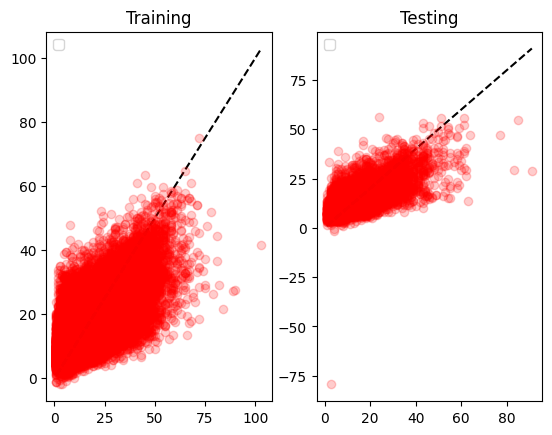

Epoch 1/50
3098/3098 [==============================] - 5s 1ms/step - loss: 71.5443 - root_mean_squared_error: 8.4584 - val_loss: 48.4925 - val_root_mean_squared_error: 6.9637
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 47.3739 - root_mean_squared_error: 6.8829 - val_loss: 45.7997 - val_root_mean_squared_error: 6.7675
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.5268 - root_mean_squared_error: 6.7474 - val_loss: 45.0062 - val_root_mean_squared_error: 6.7087
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.5726 - root_mean_squared_error: 6.6763 - val_loss: 45.2085 - val_root_mean_squared_error: 6.7237
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.0297 - root_mean_squared_error: 6.6355 - val_loss: 44.3345 - val_root_mean_squared_error: 6.6584
Epoch 6/50
3098/3098 [==============================] - 5s 1ms/step - loss: 43.5508 - root_mean_squared_error: 6.5993 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 40.2971 - root_mean_squared_error: 6.3480 - val_loss: 42.3006 - val_root_mean_squared_error: 6.5039
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.2981 - root_mean_squared_error: 6.3481 - val_loss: 41.7077 - val_root_mean_squared_error: 6.4582
Epoch 49/50
3098/3098 [==============================] - 5s 1ms/step - loss: 40.2944 - root_mean_squared_error: 6.3478 - val_loss: 42.3197 - val_root_mean_squared_error: 6.5054
Epoch 50/50
3098/3098 [==============================] - 5s 1ms/step - loss: 40.2543 - root_mean_squared_error: 6.3446 - val_loss: 41.8750 - val_root_mean_squared_error: 6.4711


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.712786808989243
linear_validation
6.675519417318537
FCM traning RMSE: 6.497763337421879


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.678592690175989


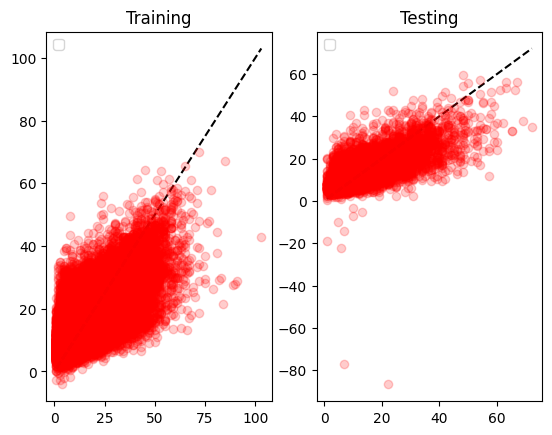

Epoch 1/50
3098/3098 [==============================] - 5s 2ms/step - loss: 71.7120 - root_mean_squared_error: 8.4683 - val_loss: 50.8885 - val_root_mean_squared_error: 7.1336
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 47.7376 - root_mean_squared_error: 6.9092 - val_loss: 47.9516 - val_root_mean_squared_error: 6.9247
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 46.0646 - root_mean_squared_error: 6.7871 - val_loss: 46.1776 - val_root_mean_squared_error: 6.7954
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.0647 - root_mean_squared_error: 6.7130 - val_loss: 45.4942 - val_root_mean_squared_error: 6.7449
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.4141 - root_mean_squared_error: 6.6644 - val_loss: 45.0259 - val_root_mean_squared_error: 6.7101
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 43.8218 - root_mean_squared_error: 6.6198 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 40.6344 - root_mean_squared_error: 6.3745 - val_loss: 41.7688 - val_root_mean_squared_error: 6.4629
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.5453 - root_mean_squared_error: 6.3675 - val_loss: 41.8391 - val_root_mean_squared_error: 6.4683
Epoch 49/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.5798 - root_mean_squared_error: 6.3702 - val_loss: 42.0165 - val_root_mean_squared_error: 6.4820
Epoch 50/50
3098/3098 [==============================] - 5s 1ms/step - loss: 40.5586 - root_mean_squared_error: 6.3686 - val_loss: 41.9970 - val_root_mean_squared_error: 6.4805


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.698856321536942
linear_validation
6.801773421500031
FCM traning RMSE: 6.507521147557852


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.668646428789935


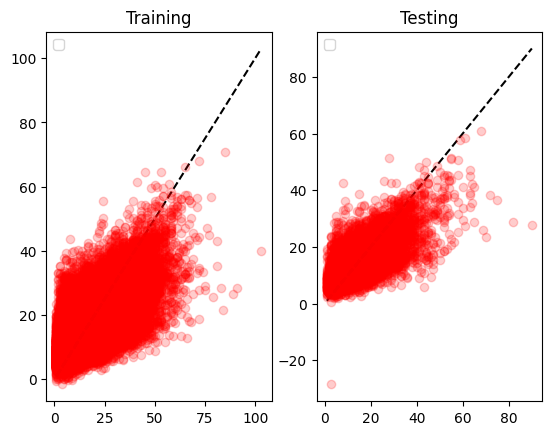

Epoch 1/50
3098/3098 [==============================] - 5s 1ms/step - loss: 73.0131 - root_mean_squared_error: 8.5448 - val_loss: 52.7905 - val_root_mean_squared_error: 7.2657
Epoch 2/50
3098/3098 [==============================] - 5s 1ms/step - loss: 48.1068 - root_mean_squared_error: 6.9359 - val_loss: 49.6038 - val_root_mean_squared_error: 7.0430
Epoch 3/50
3098/3098 [==============================] - 5s 1ms/step - loss: 46.3485 - root_mean_squared_error: 6.8080 - val_loss: 48.7379 - val_root_mean_squared_error: 6.9813
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.4046 - root_mean_squared_error: 6.7383 - val_loss: 47.0982 - val_root_mean_squared_error: 6.8628
Epoch 5/50
3098/3098 [==============================] - 5s 1ms/step - loss: 44.7611 - root_mean_squared_error: 6.6904 - val_loss: 46.7899 - val_root_mean_squared_error: 6.8403
Epoch 6/50
3098/3098 [==============================] - 5s 2ms/step - loss: 44.2828 - root_mean_squared_error: 6.6545 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 40.8024 - root_mean_squared_error: 6.3877 - val_loss: 42.5931 - val_root_mean_squared_error: 6.5263
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.7959 - root_mean_squared_error: 6.3872 - val_loss: 42.8121 - val_root_mean_squared_error: 6.5431
Epoch 49/50
3098/3098 [==============================] - 5s 1ms/step - loss: 40.7793 - root_mean_squared_error: 6.3859 - val_loss: 42.7679 - val_root_mean_squared_error: 6.5397
Epoch 50/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.8063 - root_mean_squared_error: 6.3880 - val_loss: 42.8300 - val_root_mean_squared_error: 6.5445


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.698395946008462
linear_validation
6.812586555629654
FCM traning RMSE: 6.4821783341429535


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.632788798514573


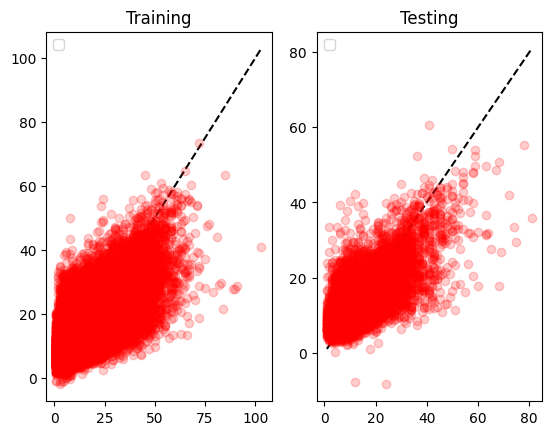

Epoch 1/50
3098/3098 [==============================] - 5s 1ms/step - loss: 70.4832 - root_mean_squared_error: 8.3954 - val_loss: 50.4096 - val_root_mean_squared_error: 7.1000
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 47.0310 - root_mean_squared_error: 6.8579 - val_loss: 47.4484 - val_root_mean_squared_error: 6.8883
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.2512 - root_mean_squared_error: 6.7269 - val_loss: 45.7980 - val_root_mean_squared_error: 6.7674
Epoch 4/50
3098/3098 [==============================] - 5s 1ms/step - loss: 44.4471 - root_mean_squared_error: 6.6669 - val_loss: 45.3054 - val_root_mean_squared_error: 6.7309
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 43.9530 - root_mean_squared_error: 6.6297 - val_loss: 44.7838 - val_root_mean_squared_error: 6.6921
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 43.5744 - root_mean_squared_error: 6.6011 - 

3098/3098 [==============================] - 5s 1ms/step - loss: 40.3257 - root_mean_squared_error: 6.3502 - val_loss: 42.1734 - val_root_mean_squared_error: 6.4941
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.2904 - root_mean_squared_error: 6.3475 - val_loss: 42.1393 - val_root_mean_squared_error: 6.4915
Epoch 49/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.2657 - root_mean_squared_error: 6.3455 - val_loss: 42.3429 - val_root_mean_squared_error: 6.5071
Epoch 50/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.2549 - root_mean_squared_error: 6.3447 - val_loss: 42.0593 - val_root_mean_squared_error: 6.4853


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.719099072374869
linear_validation
6.616486681702096
FCM traning RMSE: 6.522181111077609


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.4835239643623845


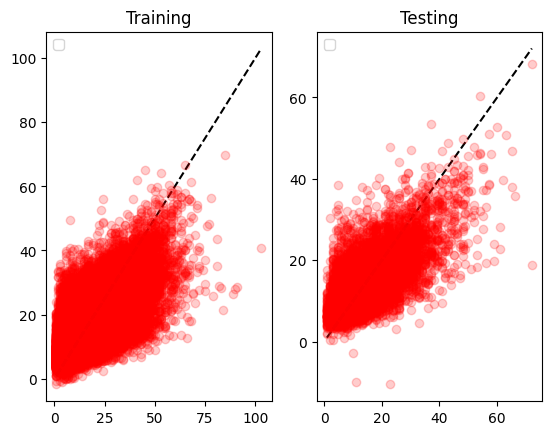

Epoch 1/50
3098/3098 [==============================] - 5s 1ms/step - loss: 71.6503 - root_mean_squared_error: 8.4647 - val_loss: 48.8779 - val_root_mean_squared_error: 6.9913
Epoch 2/50
3098/3098 [==============================] - 5s 1ms/step - loss: 47.7954 - root_mean_squared_error: 6.9134 - val_loss: 46.7310 - val_root_mean_squared_error: 6.8360
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 46.1557 - root_mean_squared_error: 6.7938 - val_loss: 46.1235 - val_root_mean_squared_error: 6.7914
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.3149 - root_mean_squared_error: 6.7316 - val_loss: 45.5817 - val_root_mean_squared_error: 6.7514
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.8433 - root_mean_squared_error: 6.6965 - val_loss: 44.8907 - val_root_mean_squared_error: 6.7001
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.3678 - root_mean_squared_error: 6.6609 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 41.4261 - root_mean_squared_error: 6.4363 - val_loss: 42.6195 - val_root_mean_squared_error: 6.5284
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 41.3898 - root_mean_squared_error: 6.4335 - val_loss: 42.4499 - val_root_mean_squared_error: 6.5154
Epoch 49/50
3098/3098 [==============================] - 4s 1ms/step - loss: 41.3905 - root_mean_squared_error: 6.4335 - val_loss: 42.6435 - val_root_mean_squared_error: 6.5302
Epoch 50/50
3098/3098 [==============================] - 5s 1ms/step - loss: 41.3587 - root_mean_squared_error: 6.4311 - val_loss: 42.4886 - val_root_mean_squared_error: 6.5183


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.70665689808311
linear_validation
6.733385654435337
FCM traning RMSE: 6.518110875475602


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.57289622277478


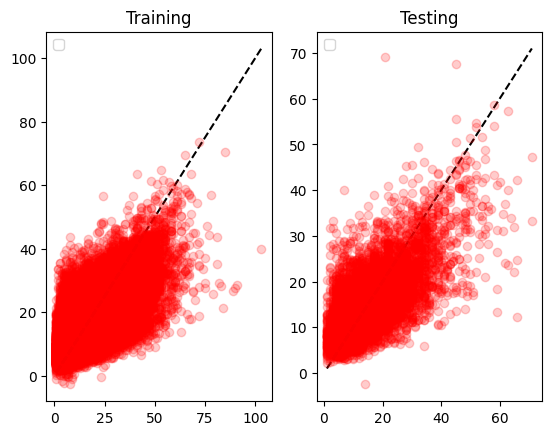

Epoch 1/50
3098/3098 [==============================] - 5s 2ms/step - loss: 71.6986 - root_mean_squared_error: 8.4675 - val_loss: 50.2374 - val_root_mean_squared_error: 7.0878
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 48.0662 - root_mean_squared_error: 6.9330 - val_loss: 47.5185 - val_root_mean_squared_error: 6.8934
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 46.3620 - root_mean_squared_error: 6.8090 - val_loss: 46.1105 - val_root_mean_squared_error: 6.7905
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.4064 - root_mean_squared_error: 6.7384 - val_loss: 45.4781 - val_root_mean_squared_error: 6.7437
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.6505 - root_mean_squared_error: 6.6821 - val_loss: 45.1581 - val_root_mean_squared_error: 6.7200
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.1857 - root_mean_squared_error: 6.6472 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 41.0191 - root_mean_squared_error: 6.4046 - val_loss: 42.4225 - val_root_mean_squared_error: 6.5133
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.9877 - root_mean_squared_error: 6.4022 - val_loss: 42.5008 - val_root_mean_squared_error: 6.5193
Epoch 49/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.9831 - root_mean_squared_error: 6.4018 - val_loss: 42.2886 - val_root_mean_squared_error: 6.5030
Epoch 50/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.9710 - root_mean_squared_error: 6.4009 - val_loss: 42.2576 - val_root_mean_squared_error: 6.5006


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.71745185801283
linear_validation
6.638614194784962
FCM traning RMSE: 6.522769429412786


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.525972781177942


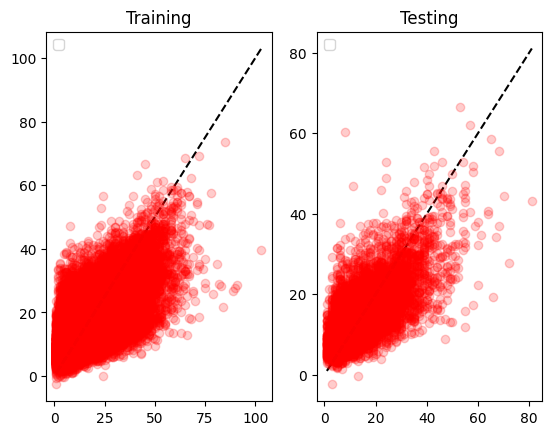

Epoch 1/50
3098/3098 [==============================] - 5s 1ms/step - loss: 70.9086 - root_mean_squared_error: 8.4207 - val_loss: 46.8325 - val_root_mean_squared_error: 6.8434
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 47.6374 - root_mean_squared_error: 6.9020 - val_loss: 44.4676 - val_root_mean_squared_error: 6.6684
Epoch 3/50
3098/3098 [==============================] - 5s 1ms/step - loss: 46.2283 - root_mean_squared_error: 6.7991 - val_loss: 43.9236 - val_root_mean_squared_error: 6.6275
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.4607 - root_mean_squared_error: 6.7425 - val_loss: 42.8180 - val_root_mean_squared_error: 6.5435
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.8215 - root_mean_squared_error: 6.6949 - val_loss: 42.8043 - val_root_mean_squared_error: 6.5425
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.3690 - root_mean_squared_error: 6.6610 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 41.1820 - root_mean_squared_error: 6.4173 - val_loss: 40.5900 - val_root_mean_squared_error: 6.3710
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 41.1607 - root_mean_squared_error: 6.4157 - val_loss: 40.4420 - val_root_mean_squared_error: 6.3594
Epoch 49/50
3098/3098 [==============================] - 4s 1ms/step - loss: 41.1125 - root_mean_squared_error: 6.4119 - val_loss: 40.4764 - val_root_mean_squared_error: 6.3621
Epoch 50/50
3098/3098 [==============================] - 5s 1ms/step - loss: 41.1352 - root_mean_squared_error: 6.4137 - val_loss: 40.7568 - val_root_mean_squared_error: 6.3841


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.709537266864461
linear_validation
6.726340363190308
FCM traning RMSE: 6.51861491795842


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.568864006837165


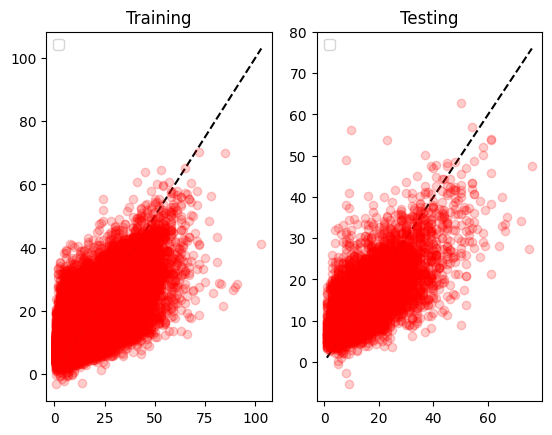

Epoch 1/50
3098/3098 [==============================] - 5s 2ms/step - loss: 71.2433 - root_mean_squared_error: 8.4406 - val_loss: 48.5373 - val_root_mean_squared_error: 6.9669
Epoch 2/50
3098/3098 [==============================] - 4s 1ms/step - loss: 47.5562 - root_mean_squared_error: 6.8961 - val_loss: 46.8397 - val_root_mean_squared_error: 6.8440
Epoch 3/50
3098/3098 [==============================] - 4s 1ms/step - loss: 46.0389 - root_mean_squared_error: 6.7852 - val_loss: 45.0164 - val_root_mean_squared_error: 6.7094
Epoch 4/50
3098/3098 [==============================] - 4s 1ms/step - loss: 45.1053 - root_mean_squared_error: 6.7160 - val_loss: 44.4952 - val_root_mean_squared_error: 6.6705
Epoch 5/50
3098/3098 [==============================] - 4s 1ms/step - loss: 44.4734 - root_mean_squared_error: 6.6688 - val_loss: 44.0442 - val_root_mean_squared_error: 6.6366
Epoch 6/50
3098/3098 [==============================] - 4s 1ms/step - loss: 43.9465 - root_mean_squared_error: 6.6292 - 

3098/3098 [==============================] - 4s 1ms/step - loss: 40.7948 - root_mean_squared_error: 6.3871 - val_loss: 41.1367 - val_root_mean_squared_error: 6.4138
Epoch 48/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.7352 - root_mean_squared_error: 6.3824 - val_loss: 41.0478 - val_root_mean_squared_error: 6.4069
Epoch 49/50
3098/3098 [==============================] - 5s 1ms/step - loss: 40.7419 - root_mean_squared_error: 6.3829 - val_loss: 41.0380 - val_root_mean_squared_error: 6.4061
Epoch 50/50
3098/3098 [==============================] - 4s 1ms/step - loss: 40.7048 - root_mean_squared_error: 6.3800 - val_loss: 40.8538 - val_root_mean_squared_error: 6.3917
target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 2
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 2
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 2
target HIGH LEVEL has neightbour_stations 0 not match nu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.2950223994665
FCM val RMSE: 6.576998003654896


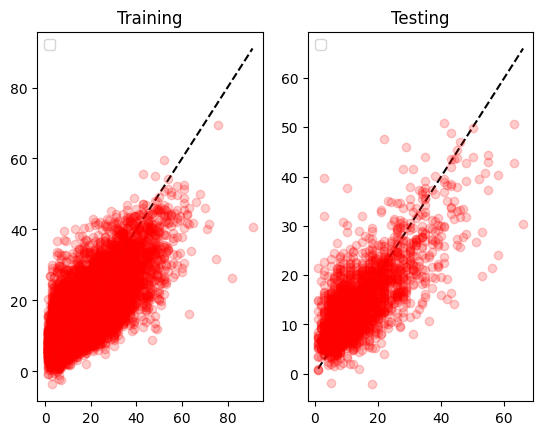

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 140.0471 - root_mean_squared_error: 11.8342 - val_loss: 79.2213 - val_root_mean_squared_error: 8.9006
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 61.9964 - root_mean_squared_error: 7.8738 - val_loss: 56.2737 - val_root_mean_squared_error: 7.5016
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 50.0859 - root_mean_squared_error: 7.0771 - val_loss: 50.0445 - val_root_mean_squared_error: 7.0742
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 46.1639 - root_mean_squared_error: 6.7944 - val_loss: 47.3437 - val_root_mean_squared_error: 6.8807
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.2306 - root_mean_squared_error: 6.6506 - val_loss: 45.6568 - val_root_mean_squared_error: 6.7570
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 43.0781 - root_mean_squared_error: 6.5634 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.5042 - root_mean_squared_error: 6.0419 - val_loss: 41.5670 - val_root_mean_squared_error: 6.4472
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.5207 - root_mean_squared_error: 6.0432 - val_loss: 41.9146 - val_root_mean_squared_error: 6.4742
Epoch 50/50
651/651 [==============================] - 1s 1ms/step - loss: 36.4018 - root_mean_squared_error: 6.0334 - val_loss: 41.7253 - val_root_mean_squared_error: 6.4595
linear train
6.56932624989256
linear_validation
6.589198229209899


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.265524127244459
FCM val RMSE: 6.553041074305781


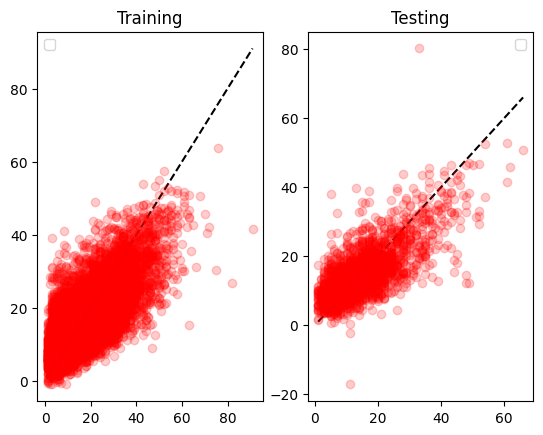

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 132.5993 - root_mean_squared_error: 11.5152 - val_loss: 72.9898 - val_root_mean_squared_error: 8.5434
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 58.2657 - root_mean_squared_error: 7.6332 - val_loss: 54.4169 - val_root_mean_squared_error: 7.3768
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 48.8144 - root_mean_squared_error: 6.9867 - val_loss: 48.6525 - val_root_mean_squared_error: 6.9751
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 45.2812 - root_mean_squared_error: 6.7291 - val_loss: 46.3687 - val_root_mean_squared_error: 6.8095
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 43.5444 - root_mean_squared_error: 6.5988 - val_loss: 44.3593 - val_root_mean_squared_error: 6.6603
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 42.4894 - root_mean_squared_error: 6.5184 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.3697 - root_mean_squared_error: 6.0307 - val_loss: 41.0723 - val_root_mean_squared_error: 6.4088
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.2830 - root_mean_squared_error: 6.0235 - val_loss: 40.7983 - val_root_mean_squared_error: 6.3874
Epoch 50/50
651/651 [==============================] - 1s 1ms/step - loss: 36.2384 - root_mean_squared_error: 6.0198 - val_loss: 40.6820 - val_root_mean_squared_error: 6.3782
linear train
6.5459305787395445
linear_validation
6.827727393125508


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.268971352852969
FCM val RMSE: 6.582068917251395


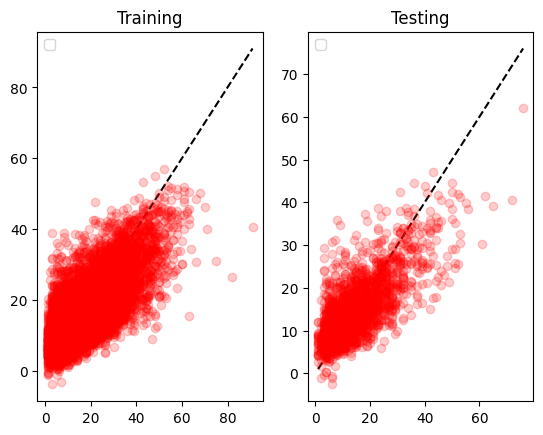

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 142.4551 - root_mean_squared_error: 11.9355 - val_loss: 81.7401 - val_root_mean_squared_error: 9.0410
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 64.1013 - root_mean_squared_error: 8.0063 - val_loss: 57.6081 - val_root_mean_squared_error: 7.5900
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 51.1853 - root_mean_squared_error: 7.1544 - val_loss: 50.9343 - val_root_mean_squared_error: 7.1368
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 46.5924 - root_mean_squared_error: 6.8259 - val_loss: 48.5816 - val_root_mean_squared_error: 6.9701
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.6760 - root_mean_squared_error: 6.6840 - val_loss: 46.6194 - val_root_mean_squared_error: 6.8278
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 43.4252 - root_mean_squared_error: 6.5898 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.4792 - root_mean_squared_error: 6.0398 - val_loss: 41.8199 - val_root_mean_squared_error: 6.4668
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.4185 - root_mean_squared_error: 6.0348 - val_loss: 42.1629 - val_root_mean_squared_error: 6.4933
Epoch 50/50
651/651 [==============================] - 1s 1ms/step - loss: 36.3781 - root_mean_squared_error: 6.0314 - val_loss: 41.4139 - val_root_mean_squared_error: 6.4354
linear train
6.574361508183147
linear_validation
6.56619295479911


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.32910782723407
FCM val RMSE: 6.369552873720094


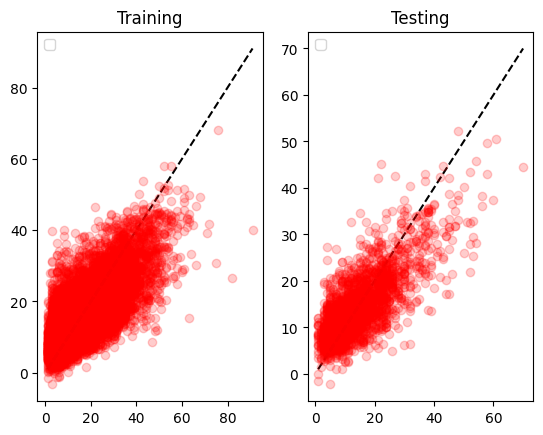

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 144.9418 - root_mean_squared_error: 12.0392 - val_loss: 81.8060 - val_root_mean_squared_error: 9.0447
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 62.9447 - root_mean_squared_error: 7.9338 - val_loss: 56.3908 - val_root_mean_squared_error: 7.5094
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 50.8745 - root_mean_squared_error: 7.1326 - val_loss: 49.7167 - val_root_mean_squared_error: 7.0510
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 47.0095 - root_mean_squared_error: 6.8563 - val_loss: 46.6862 - val_root_mean_squared_error: 6.8327
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.8699 - root_mean_squared_error: 6.6985 - val_loss: 44.9343 - val_root_mean_squared_error: 6.7033
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 43.5663 - root_mean_squared_error: 6.6005 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.7850 - root_mean_squared_error: 6.0651 - val_loss: 39.4748 - val_root_mean_squared_error: 6.2829
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.6309 - root_mean_squared_error: 6.0524 - val_loss: 39.4993 - val_root_mean_squared_error: 6.2848
Epoch 50/50
651/651 [==============================] - 1s 1ms/step - loss: 36.6381 - root_mean_squared_error: 6.0529 - val_loss: 39.3456 - val_root_mean_squared_error: 6.2726
linear train
6.595061521583757
linear_validation
6.433228233556085


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.335037621319523
FCM val RMSE: 6.7547046667658925


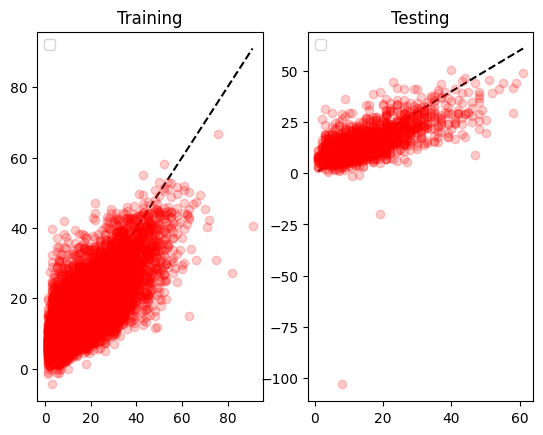

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 141.2427 - root_mean_squared_error: 11.8846 - val_loss: 66.4606 - val_root_mean_squared_error: 8.1523
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 61.0350 - root_mean_squared_error: 7.8125 - val_loss: 48.3448 - val_root_mean_squared_error: 6.9530
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 50.6604 - root_mean_squared_error: 7.1176 - val_loss: 43.4578 - val_root_mean_squared_error: 6.5923
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 46.8029 - root_mean_squared_error: 6.8413 - val_loss: 41.3247 - val_root_mean_squared_error: 6.4284
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.8705 - root_mean_squared_error: 6.6985 - val_loss: 40.2683 - val_root_mean_squared_error: 6.3457
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 43.5552 - root_mean_squared_error: 6.5996 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.9850 - root_mean_squared_error: 6.0815 - val_loss: 36.3774 - val_root_mean_squared_error: 6.0314
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.8805 - root_mean_squared_error: 6.0729 - val_loss: 36.7052 - val_root_mean_squared_error: 6.0585
Epoch 50/50
651/651 [==============================] - 1s 1ms/step - loss: 36.8071 - root_mean_squared_error: 6.0669 - val_loss: 37.0124 - val_root_mean_squared_error: 6.0838
linear train
6.578637964083007
linear_validation
6.491077641355241


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.3018517884598015
FCM val RMSE: 6.395180757185833


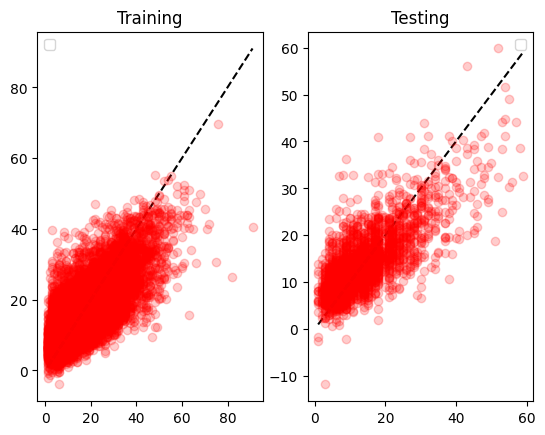

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 136.9901 - root_mean_squared_error: 11.7043 - val_loss: 71.6172 - val_root_mean_squared_error: 8.4627
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 61.8920 - root_mean_squared_error: 7.8671 - val_loss: 52.7137 - val_root_mean_squared_error: 7.2604
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 51.1090 - root_mean_squared_error: 7.1491 - val_loss: 47.6867 - val_root_mean_squared_error: 6.9056
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 47.0558 - root_mean_squared_error: 6.8597 - val_loss: 44.1017 - val_root_mean_squared_error: 6.6409
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.9080 - root_mean_squared_error: 6.7013 - val_loss: 42.9390 - val_root_mean_squared_error: 6.5528
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 43.6714 - root_mean_squared_error: 6.6084 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.8692 - root_mean_squared_error: 6.0720 - val_loss: 38.1809 - val_root_mean_squared_error: 6.1791
Epoch 49/50
651/651 [==============================] - 1s 2ms/step - loss: 36.9145 - root_mean_squared_error: 6.0757 - val_loss: 38.1141 - val_root_mean_squared_error: 6.1737
Epoch 50/50
651/651 [==============================] - 1s 2ms/step - loss: 36.8687 - root_mean_squared_error: 6.0720 - val_loss: 38.0759 - val_root_mean_squared_error: 6.1706
linear train
6.557772362253242
linear_validation
6.722778948581696


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.287424096419667
FCM val RMSE: 6.664766149440229


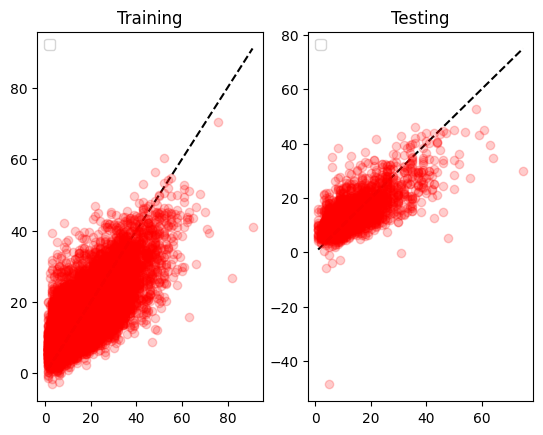

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 142.2029 - root_mean_squared_error: 11.9249 - val_loss: 74.8719 - val_root_mean_squared_error: 8.6529
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 63.8637 - root_mean_squared_error: 7.9915 - val_loss: 54.4244 - val_root_mean_squared_error: 7.3773
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 51.7693 - root_mean_squared_error: 7.1951 - val_loss: 48.5222 - val_root_mean_squared_error: 6.9658
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 47.2349 - root_mean_squared_error: 6.8728 - val_loss: 46.6873 - val_root_mean_squared_error: 6.8328
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.9988 - root_mean_squared_error: 6.7081 - val_loss: 44.5181 - val_root_mean_squared_error: 6.6722
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 43.7097 - root_mean_squared_error: 6.6113 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.6845 - root_mean_squared_error: 6.0568 - val_loss: 40.6868 - val_root_mean_squared_error: 6.3786
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.6247 - root_mean_squared_error: 6.0518 - val_loss: 40.1267 - val_root_mean_squared_error: 6.3346
Epoch 50/50
651/651 [==============================] - 1s 1ms/step - loss: 36.6430 - root_mean_squared_error: 6.0533 - val_loss: 40.4351 - val_root_mean_squared_error: 6.3589
linear train
6.555368568714976
linear_validation
6.6951357589766065


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.324458420717799
FCM val RMSE: 6.6089263436395935


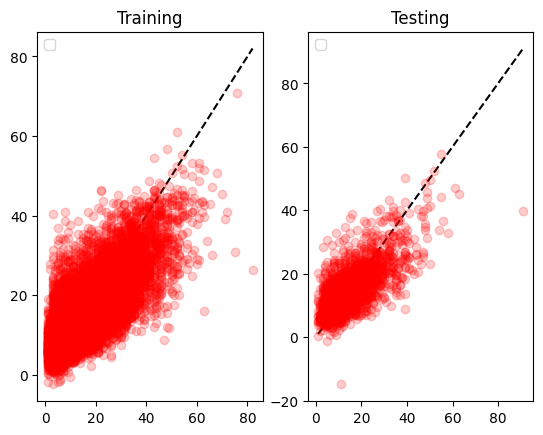

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 146.7125 - root_mean_squared_error: 12.1125 - val_loss: 80.3192 - val_root_mean_squared_error: 8.9621
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 64.7677 - root_mean_squared_error: 8.0478 - val_loss: 56.0046 - val_root_mean_squared_error: 7.4836
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 51.0707 - root_mean_squared_error: 7.1464 - val_loss: 50.2102 - val_root_mean_squared_error: 7.0859
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 46.4851 - root_mean_squared_error: 6.8180 - val_loss: 47.3137 - val_root_mean_squared_error: 6.8785
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.0986 - root_mean_squared_error: 6.6407 - val_loss: 46.7630 - val_root_mean_squared_error: 6.8384
Epoch 6/50
651/651 [==============================] - 1s 1ms/step - loss: 42.9670 - root_mean_squared_error: 6.5549 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.3247 - root_mean_squared_error: 6.0270 - val_loss: 41.3527 - val_root_mean_squared_error: 6.4306
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.2947 - root_mean_squared_error: 6.0245 - val_loss: 41.7245 - val_root_mean_squared_error: 6.4595
Epoch 50/50
651/651 [==============================] - 1s 2ms/step - loss: 36.2842 - root_mean_squared_error: 6.0236 - val_loss: 41.3861 - val_root_mean_squared_error: 6.4332
linear train
6.588757486872646
linear_validation
6.431262203411039


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.325934519804344
FCM val RMSE: 6.373706966148579


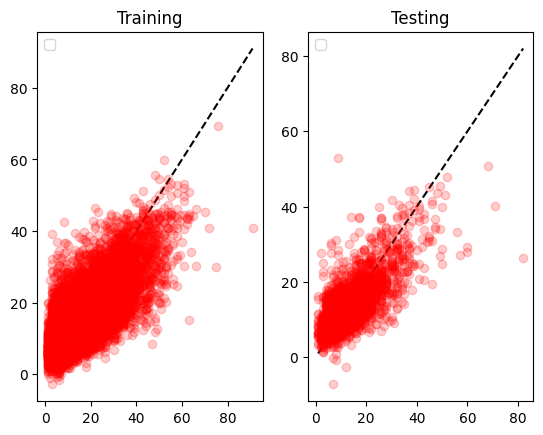

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 146.7454 - root_mean_squared_error: 12.1139 - val_loss: 75.6600 - val_root_mean_squared_error: 8.6983
Epoch 2/50
651/651 [==============================] - 1s 1ms/step - loss: 65.2058 - root_mean_squared_error: 8.0750 - val_loss: 50.4274 - val_root_mean_squared_error: 7.1012
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 50.5015 - root_mean_squared_error: 7.1064 - val_loss: 44.4732 - val_root_mean_squared_error: 6.6688
Epoch 4/50
651/651 [==============================] - 1s 1ms/step - loss: 46.6415 - root_mean_squared_error: 6.8295 - val_loss: 42.3102 - val_root_mean_squared_error: 6.5046
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.6215 - root_mean_squared_error: 6.6799 - val_loss: 41.2220 - val_root_mean_squared_error: 6.4204
Epoch 6/50
651/651 [==============================] - 1s 2ms/step - loss: 43.4412 - root_mean_squared_error: 6.5910 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.8250 - root_mean_squared_error: 6.0684 - val_loss: 38.1605 - val_root_mean_squared_error: 6.1774
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.6706 - root_mean_squared_error: 6.0556 - val_loss: 38.5067 - val_root_mean_squared_error: 6.2054
Epoch 50/50
651/651 [==============================] - 1s 1ms/step - loss: 36.7429 - root_mean_squared_error: 6.0616 - val_loss: 38.0920 - val_root_mean_squared_error: 6.1719
linear train
6.548090667128455
linear_validation
6.774578500982441


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 6.267783707184609
FCM val RMSE: 6.79273175131263


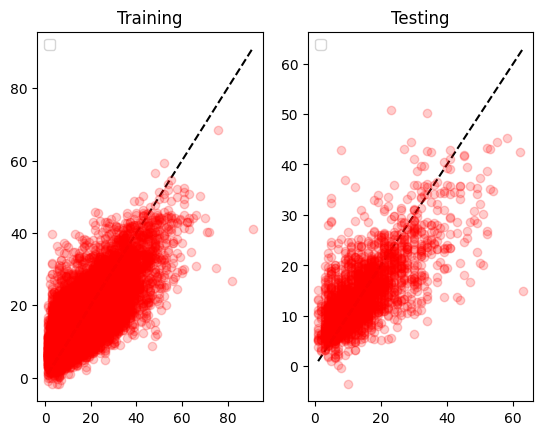

Epoch 1/50
651/651 [==============================] - 1s 2ms/step - loss: 139.7375 - root_mean_squared_error: 11.8211 - val_loss: 73.5631 - val_root_mean_squared_error: 8.5769
Epoch 2/50
651/651 [==============================] - 1s 2ms/step - loss: 59.9532 - root_mean_squared_error: 7.7429 - val_loss: 56.2669 - val_root_mean_squared_error: 7.5011
Epoch 3/50
651/651 [==============================] - 1s 1ms/step - loss: 49.7609 - root_mean_squared_error: 7.0541 - val_loss: 50.9201 - val_root_mean_squared_error: 7.1358
Epoch 4/50
651/651 [==============================] - 1s 2ms/step - loss: 45.9703 - root_mean_squared_error: 6.7801 - val_loss: 48.0976 - val_root_mean_squared_error: 6.9352
Epoch 5/50
651/651 [==============================] - 1s 1ms/step - loss: 44.0033 - root_mean_squared_error: 6.6335 - val_loss: 46.7641 - val_root_mean_squared_error: 6.8384
Epoch 6/50
651/651 [==============================] - 1s 2ms/step - loss: 42.8307 - root_mean_squared_error: 6.5445 - val_loss: 

Epoch 48/50
651/651 [==============================] - 1s 1ms/step - loss: 36.2511 - root_mean_squared_error: 6.0209 - val_loss: 43.3089 - val_root_mean_squared_error: 6.5810
Epoch 49/50
651/651 [==============================] - 1s 1ms/step - loss: 36.0690 - root_mean_squared_error: 6.0057 - val_loss: 43.8851 - val_root_mean_squared_error: 6.6246
Epoch 50/50
651/651 [==============================] - 1s 2ms/step - loss: 36.1472 - root_mean_squared_error: 6.0123 - val_loss: 43.5815 - val_root_mean_squared_error: 6.6016
target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 3
target RED EARTH has neightbour_stations 2 not match number_of_neighbours 3
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 3
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 3
target HIGH LEVEL has neightbour_stations 0 not match number_of_neighbours 3
target JASPER WARDEN has neightbour_stations 2 not match number_of_neighbo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.858264631429537
FCM val RMSE: 117.69331848257885


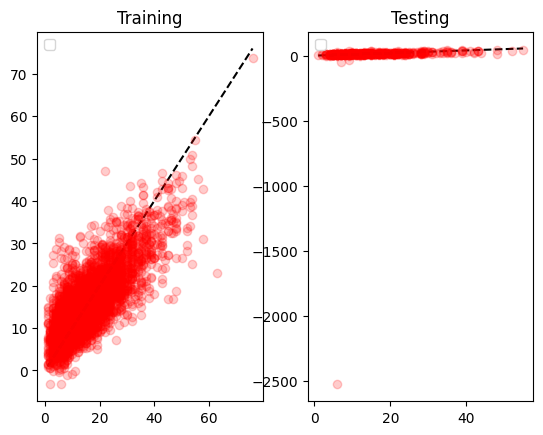

Epoch 1/50
131/131 [==============================] - 0s 2ms/step - loss: 279.8748 - root_mean_squared_error: 16.7295 - val_loss: 247.0773 - val_root_mean_squared_error: 15.7187
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 199.5561 - root_mean_squared_error: 14.1264 - val_loss: 171.2394 - val_root_mean_squared_error: 13.0858
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 139.6443 - root_mean_squared_error: 11.8171 - val_loss: 122.0185 - val_root_mean_squared_error: 11.0462
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 104.6170 - root_mean_squared_error: 10.2282 - val_loss: 94.8534 - val_root_mean_squared_error: 9.7393
Epoch 5/50
131/131 [==============================] - 0s 1ms/step - loss: 85.5275 - root_mean_squared_error: 9.2481 - val_loss: 79.6643 - val_root_mean_squared_error: 8.9255
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 74.7925 - root_mean_squared_error: 8.6483 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 40.4078 - root_mean_squared_error: 6.3567 - val_loss: 44.4729 - val_root_mean_squared_error: 6.6688
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 39.9457 - root_mean_squared_error: 6.3203 - val_loss: 44.7395 - val_root_mean_squared_error: 6.6888
Epoch 50/50
131/131 [==============================] - 0s 1ms/step - loss: 40.0340 - root_mean_squared_error: 6.3272 - val_loss: 44.7471 - val_root_mean_squared_error: 6.6893
linear train
6.458669241997619
linear_validation
976971619142.6666


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.897004471639663
FCM val RMSE: 82.44017273392929


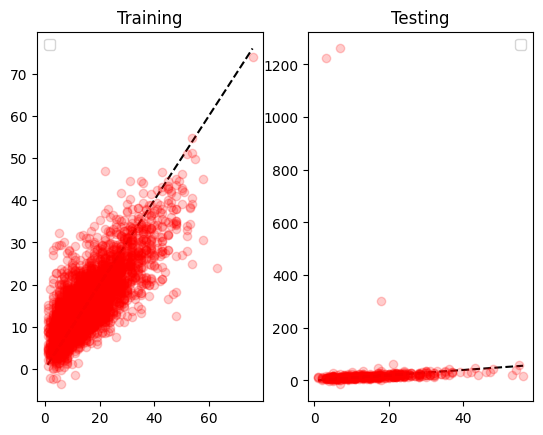

Epoch 1/50
131/131 [==============================] - 0s 2ms/step - loss: 280.8123 - root_mean_squared_error: 16.7575 - val_loss: 251.1786 - val_root_mean_squared_error: 15.8486
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 198.8454 - root_mean_squared_error: 14.1013 - val_loss: 172.1401 - val_root_mean_squared_error: 13.1202
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 138.4450 - root_mean_squared_error: 11.7663 - val_loss: 126.1650 - val_root_mean_squared_error: 11.2323
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 104.8398 - root_mean_squared_error: 10.2391 - val_loss: 100.1182 - val_root_mean_squared_error: 10.0059
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 85.9738 - root_mean_squared_error: 9.2722 - val_loss: 85.0387 - val_root_mean_squared_error: 9.2216
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 74.9597 - root_mean_squared_error: 8.657

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 38.9977 - root_mean_squared_error: 6.2448 - val_loss: 58.2467 - val_root_mean_squared_error: 7.6319
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 38.8226 - root_mean_squared_error: 6.2308 - val_loss: 59.0926 - val_root_mean_squared_error: 7.6872
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 38.6900 - root_mean_squared_error: 6.2201 - val_loss: 58.0828 - val_root_mean_squared_error: 7.6212
linear train
6.435220834540207
linear_validation
6.434868076890997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.963329563956553
FCM val RMSE: 8.480700669299113


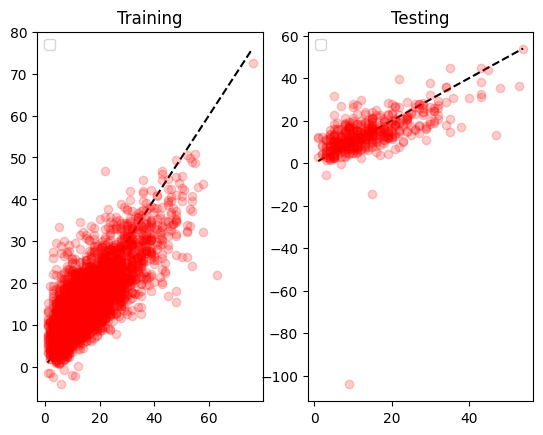

Epoch 1/50
131/131 [==============================] - 0s 3ms/step - loss: 280.4653 - root_mean_squared_error: 16.7471 - val_loss: 212.0965 - val_root_mean_squared_error: 14.5635
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 200.0931 - root_mean_squared_error: 14.1454 - val_loss: 147.5072 - val_root_mean_squared_error: 12.1453
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 141.4114 - root_mean_squared_error: 11.8917 - val_loss: 105.3842 - val_root_mean_squared_error: 10.2657
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 106.1049 - root_mean_squared_error: 10.3007 - val_loss: 83.1521 - val_root_mean_squared_error: 9.1188
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 86.3692 - root_mean_squared_error: 9.2935 - val_loss: 71.7746 - val_root_mean_squared_error: 8.4720
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 75.5603 - root_mean_squared_error: 8.6925 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 40.2786 - root_mean_squared_error: 6.3465 - val_loss: 41.9335 - val_root_mean_squared_error: 6.4756
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 40.1465 - root_mean_squared_error: 6.3361 - val_loss: 41.6697 - val_root_mean_squared_error: 6.4552
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 39.9081 - root_mean_squared_error: 6.3173 - val_loss: 42.0668 - val_root_mean_squared_error: 6.4859
linear train
6.396759560748953
linear_validation
6.771726282712149


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.87934008153016
FCM val RMSE: 10.847465672146178


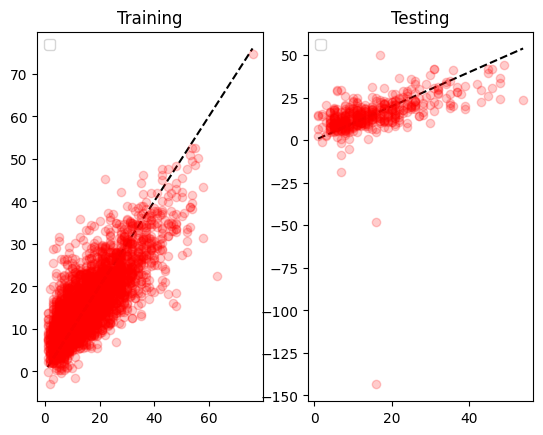

Epoch 1/50
131/131 [==============================] - 0s 2ms/step - loss: 279.3091 - root_mean_squared_error: 16.7125 - val_loss: 232.6903 - val_root_mean_squared_error: 15.2542
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 199.5209 - root_mean_squared_error: 14.1252 - val_loss: 159.1689 - val_root_mean_squared_error: 12.6162
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 140.7248 - root_mean_squared_error: 11.8627 - val_loss: 118.4023 - val_root_mean_squared_error: 10.8813
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 109.6826 - root_mean_squared_error: 10.4729 - val_loss: 96.9414 - val_root_mean_squared_error: 9.8459
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 91.5618 - root_mean_squared_error: 9.5688 - val_loss: 84.0209 - val_root_mean_squared_error: 9.1663
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 79.7871 - root_mean_squared_error: 8.9324 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 39.9312 - root_mean_squared_error: 6.3191 - val_loss: 51.7022 - val_root_mean_squared_error: 7.1904
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 39.6202 - root_mean_squared_error: 6.2945 - val_loss: 52.2377 - val_root_mean_squared_error: 7.2276
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 39.6299 - root_mean_squared_error: 6.2952 - val_loss: 51.9615 - val_root_mean_squared_error: 7.2084
linear train
6.385665618497549
linear_validation
6.887672517017704


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.778869447816352
FCM val RMSE: 8.625437269790707


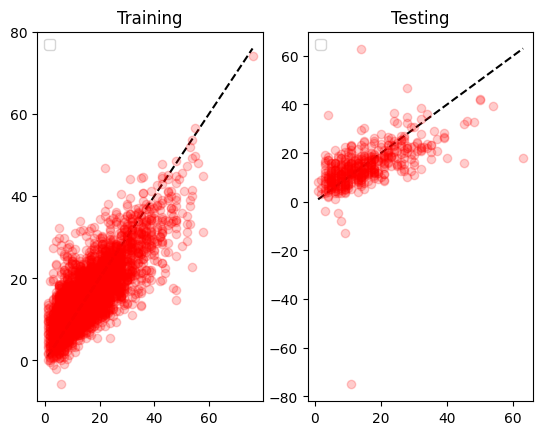

Epoch 1/50
131/131 [==============================] - 0s 2ms/step - loss: 282.4332 - root_mean_squared_error: 16.8057 - val_loss: 239.5953 - val_root_mean_squared_error: 15.4789
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 199.0020 - root_mean_squared_error: 14.1068 - val_loss: 161.1958 - val_root_mean_squared_error: 12.6963
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 135.8245 - root_mean_squared_error: 11.6544 - val_loss: 113.2895 - val_root_mean_squared_error: 10.6438
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 100.7885 - root_mean_squared_error: 10.0393 - val_loss: 89.8141 - val_root_mean_squared_error: 9.4770
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 82.0108 - root_mean_squared_error: 9.0560 - val_loss: 77.1662 - val_root_mean_squared_error: 8.7844
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 71.5249 - root_mean_squared_error: 8.4572 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 38.6302 - root_mean_squared_error: 6.2153 - val_loss: 47.2537 - val_root_mean_squared_error: 6.8741
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 38.5479 - root_mean_squared_error: 6.2087 - val_loss: 47.6650 - val_root_mean_squared_error: 6.9040
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 38.3650 - root_mean_squared_error: 6.1940 - val_loss: 48.2722 - val_root_mean_squared_error: 6.9478
linear train
6.448635830162927
linear_validation
5811050504.166782


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.7699085205322715
FCM val RMSE: 227.9489979262599


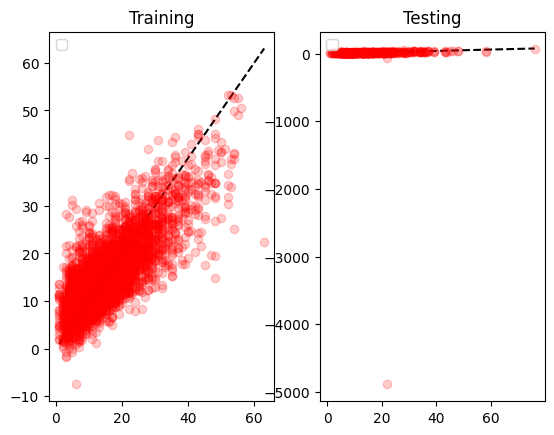

Epoch 1/50
131/131 [==============================] - 0s 2ms/step - loss: 281.9398 - root_mean_squared_error: 16.7911 - val_loss: 251.5704 - val_root_mean_squared_error: 15.8610
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 196.2659 - root_mean_squared_error: 14.0095 - val_loss: 171.8312 - val_root_mean_squared_error: 13.1084
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 133.8768 - root_mean_squared_error: 11.5705 - val_loss: 124.3733 - val_root_mean_squared_error: 11.1523
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 99.6423 - root_mean_squared_error: 9.9821 - val_loss: 99.2280 - val_root_mean_squared_error: 9.9613
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 81.8264 - root_mean_squared_error: 9.0458 - val_loss: 85.9259 - val_root_mean_squared_error: 9.2696
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 71.4745 - root_mean_squared_error: 8.4543 - 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 38.0477 - root_mean_squared_error: 6.1683 - val_loss: 50.2571 - val_root_mean_squared_error: 7.0892
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 37.8901 - root_mean_squared_error: 6.1555 - val_loss: 49.8234 - val_root_mean_squared_error: 7.0586
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 37.7973 - root_mean_squared_error: 6.1480 - val_loss: 50.5244 - val_root_mean_squared_error: 7.1081
linear train
6.4406736169331635
linear_validation
130164266729.52577


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.833809575888818
FCM val RMSE: 58.30685396829031


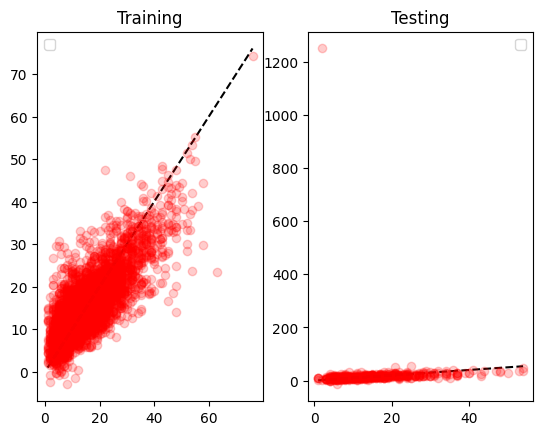

Epoch 1/50
131/131 [==============================] - 0s 2ms/step - loss: 278.3158 - root_mean_squared_error: 16.6828 - val_loss: 244.6470 - val_root_mean_squared_error: 15.6412
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 196.3464 - root_mean_squared_error: 14.0124 - val_loss: 168.9847 - val_root_mean_squared_error: 12.9994
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 137.6636 - root_mean_squared_error: 11.7330 - val_loss: 123.5955 - val_root_mean_squared_error: 11.1174
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 104.7050 - root_mean_squared_error: 10.2325 - val_loss: 99.3564 - val_root_mean_squared_error: 9.9678
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 86.2753 - root_mean_squared_error: 9.2885 - val_loss: 84.1007 - val_root_mean_squared_error: 9.1706
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 74.9983 - root_mean_squared_error: 8.6602 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 38.0540 - root_mean_squared_error: 6.1688 - val_loss: 46.2173 - val_root_mean_squared_error: 6.7983
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 37.9540 - root_mean_squared_error: 6.1607 - val_loss: 45.9666 - val_root_mean_squared_error: 6.7799
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 38.0220 - root_mean_squared_error: 6.1662 - val_loss: 45.4025 - val_root_mean_squared_error: 6.7381
linear train
6.417266629049906
linear_validation
14946274028.833336


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.752064286682954
FCM val RMSE: 12.338940046261499


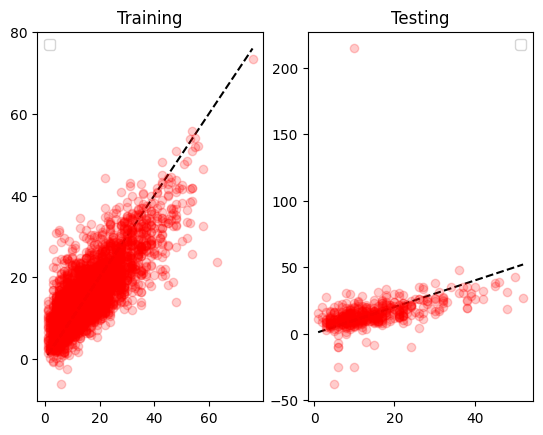

Epoch 1/50
131/131 [==============================] - 0s 3ms/step - loss: 280.2676 - root_mean_squared_error: 16.7412 - val_loss: 218.6447 - val_root_mean_squared_error: 14.7866
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 198.0332 - root_mean_squared_error: 14.0724 - val_loss: 149.5750 - val_root_mean_squared_error: 12.2301
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 139.7474 - root_mean_squared_error: 11.8215 - val_loss: 109.6198 - val_root_mean_squared_error: 10.4699
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 106.6720 - root_mean_squared_error: 10.3282 - val_loss: 87.7978 - val_root_mean_squared_error: 9.3700
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 86.7849 - root_mean_squared_error: 9.3158 - val_loss: 75.0373 - val_root_mean_squared_error: 8.6624
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 74.3269 - root_mean_squared_error: 8.6213 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 38.6087 - root_mean_squared_error: 6.2136 - val_loss: 49.9426 - val_root_mean_squared_error: 7.0670
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 38.2222 - root_mean_squared_error: 6.1824 - val_loss: 50.5075 - val_root_mean_squared_error: 7.1069
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 38.2808 - root_mean_squared_error: 6.1871 - val_loss: 49.2271 - val_root_mean_squared_error: 7.0162
linear train
6.422892399845245
linear_validation
2621312356.64045


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.876045528092478
FCM val RMSE: 12.859751923391949


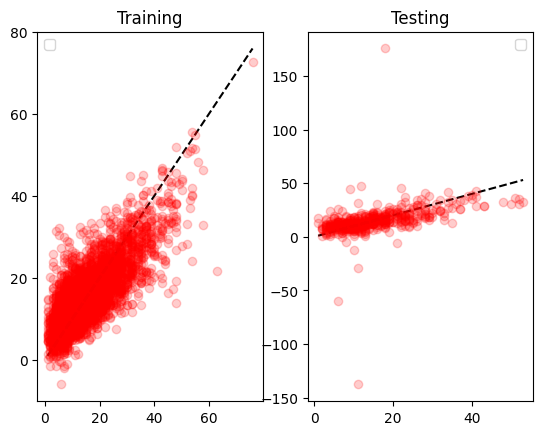

Epoch 1/50
131/131 [==============================] - 0s 3ms/step - loss: 284.5643 - root_mean_squared_error: 16.8690 - val_loss: 251.4358 - val_root_mean_squared_error: 15.8567
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 205.6749 - root_mean_squared_error: 14.3414 - val_loss: 176.4459 - val_root_mean_squared_error: 13.2833
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 142.3635 - root_mean_squared_error: 11.9316 - val_loss: 124.2199 - val_root_mean_squared_error: 11.1454
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 104.8205 - root_mean_squared_error: 10.2382 - val_loss: 96.1107 - val_root_mean_squared_error: 9.8036
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 85.2544 - root_mean_squared_error: 9.2333 - val_loss: 80.4184 - val_root_mean_squared_error: 8.9676
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 74.2392 - root_mean_squared_error: 8.6162 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 39.8111 - root_mean_squared_error: 6.3096 - val_loss: 46.9877 - val_root_mean_squared_error: 6.8548
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 39.5218 - root_mean_squared_error: 6.2866 - val_loss: 45.9923 - val_root_mean_squared_error: 6.7818
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 39.4979 - root_mean_squared_error: 6.2847 - val_loss: 46.4276 - val_root_mean_squared_error: 6.8138
linear train
6.420445646514365
linear_validation
6.665779724569056


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.799590071400651
FCM val RMSE: 10.339887294584903


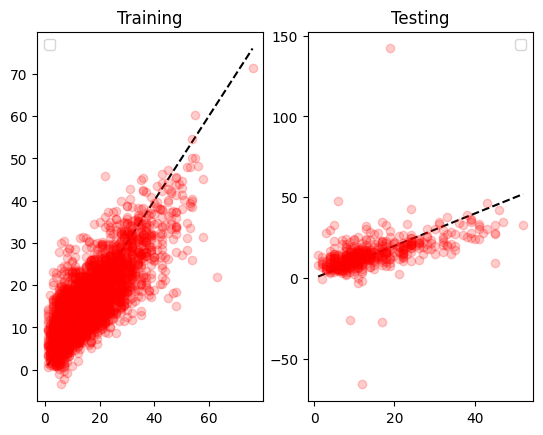

Epoch 1/50
131/131 [==============================] - 0s 3ms/step - loss: 277.1877 - root_mean_squared_error: 16.6490 - val_loss: 230.9892 - val_root_mean_squared_error: 15.1983
Epoch 2/50
131/131 [==============================] - 0s 2ms/step - loss: 189.3085 - root_mean_squared_error: 13.7589 - val_loss: 154.7706 - val_root_mean_squared_error: 12.4407
Epoch 3/50
131/131 [==============================] - 0s 2ms/step - loss: 126.5726 - root_mean_squared_error: 11.2504 - val_loss: 110.5764 - val_root_mean_squared_error: 10.5155
Epoch 4/50
131/131 [==============================] - 0s 2ms/step - loss: 94.0282 - root_mean_squared_error: 9.6968 - val_loss: 88.7404 - val_root_mean_squared_error: 9.4202
Epoch 5/50
131/131 [==============================] - 0s 2ms/step - loss: 78.1156 - root_mean_squared_error: 8.8383 - val_loss: 76.9673 - val_root_mean_squared_error: 8.7731
Epoch 6/50
131/131 [==============================] - 0s 2ms/step - loss: 69.0634 - root_mean_squared_error: 8.3104 - 

Epoch 48/50
131/131 [==============================] - 0s 2ms/step - loss: 39.3201 - root_mean_squared_error: 6.2706 - val_loss: 47.3269 - val_root_mean_squared_error: 6.8795
Epoch 49/50
131/131 [==============================] - 0s 2ms/step - loss: 39.3435 - root_mean_squared_error: 6.2724 - val_loss: 46.9668 - val_root_mean_squared_error: 6.8532
Epoch 50/50
131/131 [==============================] - 0s 2ms/step - loss: 39.2343 - root_mean_squared_error: 6.2637 - val_loss: 46.9292 - val_root_mean_squared_error: 6.8505
target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 4
target RED EARTH has neightbour_stations 2 not match number_of_neighbours 4
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 4
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 4
target LLOYDMINSTER has neightbour_stations 3 not match number_of_neighbours 4
target HIGH LEVEL has neightbour_stations 0 not match number_of_neighbou

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.945543545985285
FCM val RMSE: 7319.036848112035


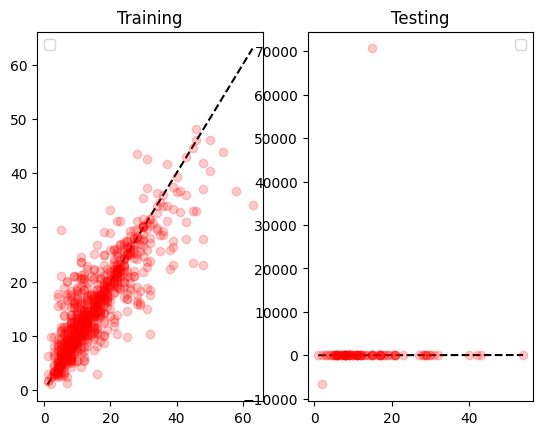

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 319.4300 - root_mean_squared_error: 17.8726 - val_loss: 269.5553 - val_root_mean_squared_error: 16.4181
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 291.7907 - root_mean_squared_error: 17.0819 - val_loss: 251.4864 - val_root_mean_squared_error: 15.8583
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 274.1202 - root_mean_squared_error: 16.5566 - val_loss: 235.5516 - val_root_mean_squared_error: 15.3477
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 257.6151 - root_mean_squared_error: 16.0504 - val_loss: 221.0274 - val_root_mean_squared_error: 14.8670
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 241.0869 - root_mean_squared_error: 15.5270 - val_loss: 205.7707 - val_root_mean_squared_error: 14.3447
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 225.2929 - root_mean_squared_error: 15.0098 - va

27/27 [==============================] - 0s 2ms/step - loss: 56.6225 - root_mean_squared_error: 7.5248 - val_loss: 52.3805 - val_root_mean_squared_error: 7.2374
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 56.0355 - root_mean_squared_error: 7.4857 - val_loss: 51.7237 - val_root_mean_squared_error: 7.1919
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 55.5126 - root_mean_squared_error: 7.4507 - val_loss: 51.5579 - val_root_mean_squared_error: 7.1804
linear train
6.332607361525471
linear_validation
7.187467049659756


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.585614270232925
FCM val RMSE: 101.31469426198139


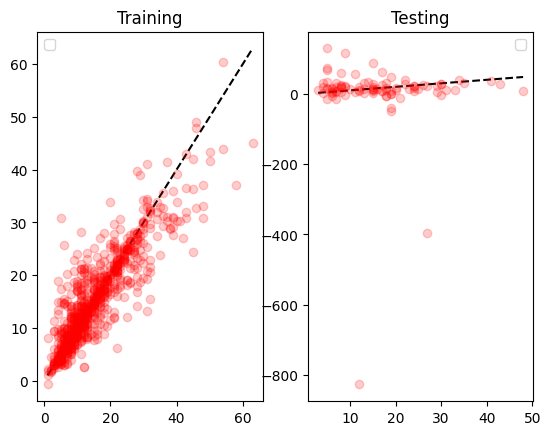

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 306.4218 - root_mean_squared_error: 17.5049 - val_loss: 316.4076 - val_root_mean_squared_error: 17.7878
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 284.9500 - root_mean_squared_error: 16.8805 - val_loss: 297.3346 - val_root_mean_squared_error: 17.2434
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 266.3008 - root_mean_squared_error: 16.3187 - val_loss: 278.9498 - val_root_mean_squared_error: 16.7018
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 249.3304 - root_mean_squared_error: 15.7902 - val_loss: 260.2537 - val_root_mean_squared_error: 16.1324
Epoch 5/50
27/27 [==============================] - 0s 2ms/step - loss: 232.4502 - root_mean_squared_error: 15.2463 - val_loss: 243.1575 - val_root_mean_squared_error: 15.5935
Epoch 6/50
27/27 [==============================] - 0s 2ms/step - loss: 216.1137 - root_mean_squared_error: 14.7008 - va

Epoch 48/50
27/27 [==============================] - 0s 2ms/step - loss: 56.8593 - root_mean_squared_error: 7.5405 - val_loss: 70.2070 - val_root_mean_squared_error: 8.3790
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 56.4111 - root_mean_squared_error: 7.5107 - val_loss: 71.5920 - val_root_mean_squared_error: 8.4612
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 55.8018 - root_mean_squared_error: 7.4701 - val_loss: 70.7022 - val_root_mean_squared_error: 8.4085
linear train
6.5897360498693605
linear_validation
7.116617395557531


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.85055168396453
FCM val RMSE: 165.50732735100823


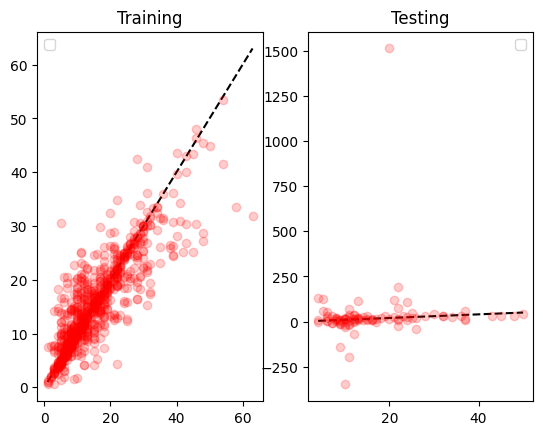

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 304.8860 - root_mean_squared_error: 17.4610 - val_loss: 358.4016 - val_root_mean_squared_error: 18.9315
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 283.5309 - root_mean_squared_error: 16.8384 - val_loss: 341.8850 - val_root_mean_squared_error: 18.4901
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 266.0602 - root_mean_squared_error: 16.3114 - val_loss: 321.3735 - val_root_mean_squared_error: 17.9269
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 249.2267 - root_mean_squared_error: 15.7869 - val_loss: 301.7380 - val_root_mean_squared_error: 17.3706
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 232.5305 - root_mean_squared_error: 15.2490 - val_loss: 283.9777 - val_root_mean_squared_error: 16.8516
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 217.6384 - root_mean_squared_error: 14.7526 - va

Epoch 48/50
27/27 [==============================] - 0s 2ms/step - loss: 58.8024 - root_mean_squared_error: 7.6683 - val_loss: 64.7655 - val_root_mean_squared_error: 8.0477
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 58.3088 - root_mean_squared_error: 7.6360 - val_loss: 64.5278 - val_root_mean_squared_error: 8.0329
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 57.7097 - root_mean_squared_error: 7.5967 - val_loss: 63.5915 - val_root_mean_squared_error: 7.9744
linear train
6.460299611483609
linear_validation
142884692755.76553


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.784002443705325
FCM val RMSE: 6085.351033566161


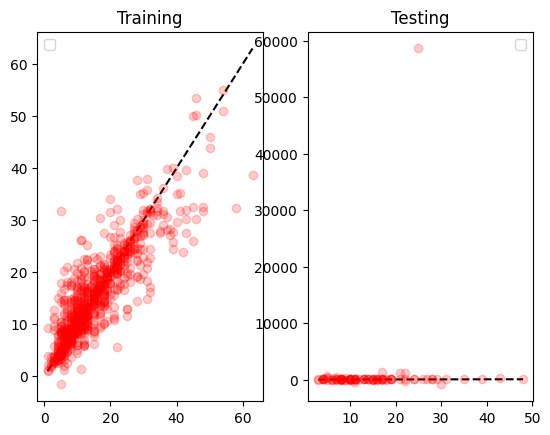

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 314.3213 - root_mean_squared_error: 17.7291 - val_loss: 265.1646 - val_root_mean_squared_error: 16.2839
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 291.1848 - root_mean_squared_error: 17.0641 - val_loss: 251.6505 - val_root_mean_squared_error: 15.8635
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 272.2159 - root_mean_squared_error: 16.4990 - val_loss: 240.0088 - val_root_mean_squared_error: 15.4922
Epoch 4/50
27/27 [==============================] - 0s 2ms/step - loss: 253.8470 - root_mean_squared_error: 15.9326 - val_loss: 228.1960 - val_root_mean_squared_error: 15.1062
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 237.0925 - root_mean_squared_error: 15.3978 - val_loss: 216.3206 - val_root_mean_squared_error: 14.7078
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 220.9690 - root_mean_squared_error: 14.8650 - va

Epoch 48/50
27/27 [==============================] - 0s 2ms/step - loss: 56.6054 - root_mean_squared_error: 7.5237 - val_loss: 85.4017 - val_root_mean_squared_error: 9.2413
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 56.1365 - root_mean_squared_error: 7.4924 - val_loss: 85.2934 - val_root_mean_squared_error: 9.2354
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 55.5545 - root_mean_squared_error: 7.4535 - val_loss: 84.9157 - val_root_mean_squared_error: 9.2150
linear train
6.423925770240291
linear_validation
6.5018185376549935


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.498468972494197
FCM val RMSE: 63.337861869863204


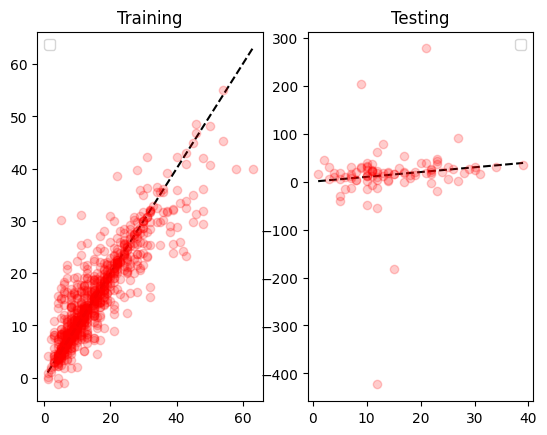

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 315.4471 - root_mean_squared_error: 17.7608 - val_loss: 263.4651 - val_root_mean_squared_error: 16.2316
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 290.4095 - root_mean_squared_error: 17.0414 - val_loss: 245.2384 - val_root_mean_squared_error: 15.6601
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 269.6099 - root_mean_squared_error: 16.4198 - val_loss: 225.0439 - val_root_mean_squared_error: 15.0015
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 250.3027 - root_mean_squared_error: 15.8210 - val_loss: 205.7715 - val_root_mean_squared_error: 14.3447
Epoch 5/50
27/27 [==============================] - 0s 2ms/step - loss: 232.4854 - root_mean_squared_error: 15.2475 - val_loss: 188.5495 - val_root_mean_squared_error: 13.7313
Epoch 6/50
27/27 [==============================] - 0s 2ms/step - loss: 215.9462 - root_mean_squared_error: 14.6951 - va

27/27 [==============================] - 0s 2ms/step - loss: 57.9780 - root_mean_squared_error: 7.6143 - val_loss: 47.2950 - val_root_mean_squared_error: 6.8771
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 57.1301 - root_mean_squared_error: 7.5584 - val_loss: 46.6002 - val_root_mean_squared_error: 6.8264
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 56.5500 - root_mean_squared_error: 7.5200 - val_loss: 46.5643 - val_root_mean_squared_error: 6.8238
linear train
8.93783950972427
linear_validation
14.812317724751775


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.908738108083896
FCM val RMSE: 1319.470939696746


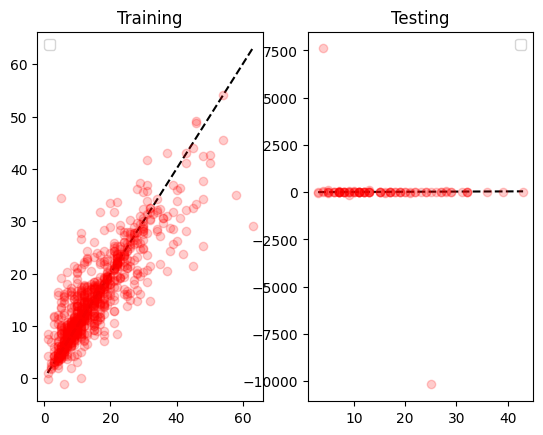

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 314.5010 - root_mean_squared_error: 17.7342 - val_loss: 271.2371 - val_root_mean_squared_error: 16.4693
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 286.7883 - root_mean_squared_error: 16.9348 - val_loss: 251.0521 - val_root_mean_squared_error: 15.8446
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 266.2137 - root_mean_squared_error: 16.3161 - val_loss: 233.4358 - val_root_mean_squared_error: 15.2786
Epoch 4/50
27/27 [==============================] - 0s 2ms/step - loss: 246.8954 - root_mean_squared_error: 15.7129 - val_loss: 217.5461 - val_root_mean_squared_error: 14.7494
Epoch 5/50
27/27 [==============================] - 0s 2ms/step - loss: 229.9436 - root_mean_squared_error: 15.1639 - val_loss: 203.2065 - val_root_mean_squared_error: 14.2551
Epoch 6/50
27/27 [==============================] - 0s 2ms/step - loss: 214.5814 - root_mean_squared_error: 14.6486 - va

Epoch 48/50
27/27 [==============================] - 0s 2ms/step - loss: 56.0525 - root_mean_squared_error: 7.4868 - val_loss: 66.4841 - val_root_mean_squared_error: 8.1538
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 55.6601 - root_mean_squared_error: 7.4606 - val_loss: 66.4877 - val_root_mean_squared_error: 8.1540
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 54.9907 - root_mean_squared_error: 7.4156 - val_loss: 66.2207 - val_root_mean_squared_error: 8.1376
linear train
6.582990483360131
linear_validation
15231117051531.037


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.2533033523339805
FCM val RMSE: 328.031508431336


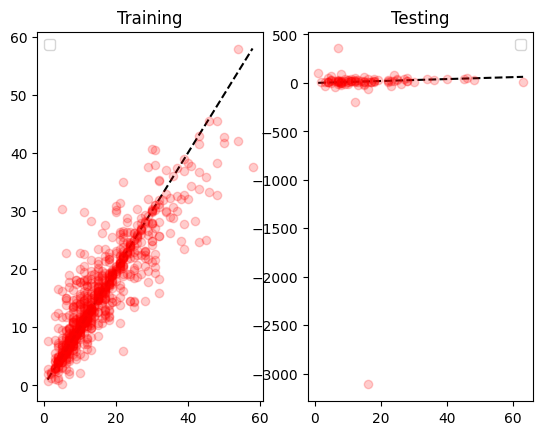

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 303.5490 - root_mean_squared_error: 17.4227 - val_loss: 307.4190 - val_root_mean_squared_error: 17.5334
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 280.7310 - root_mean_squared_error: 16.7550 - val_loss: 285.1004 - val_root_mean_squared_error: 16.8849
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 260.4762 - root_mean_squared_error: 16.1393 - val_loss: 265.8544 - val_root_mean_squared_error: 16.3050
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 241.3867 - root_mean_squared_error: 15.5366 - val_loss: 248.4576 - val_root_mean_squared_error: 15.7625
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 223.2811 - root_mean_squared_error: 14.9426 - val_loss: 231.9177 - val_root_mean_squared_error: 15.2288
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 206.6890 - root_mean_squared_error: 14.3767 - va

Epoch 48/50
27/27 [==============================] - 0s 2ms/step - loss: 53.0958 - root_mean_squared_error: 7.2867 - val_loss: 96.4099 - val_root_mean_squared_error: 9.8189
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 52.6833 - root_mean_squared_error: 7.2583 - val_loss: 94.4540 - val_root_mean_squared_error: 9.7187
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 52.1399 - root_mean_squared_error: 7.2208 - val_loss: 94.8520 - val_root_mean_squared_error: 9.7392
linear train
6.272112561126712
linear_validation
7.9210069544781465


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.159536904189565
FCM val RMSE: 46.97401778310358


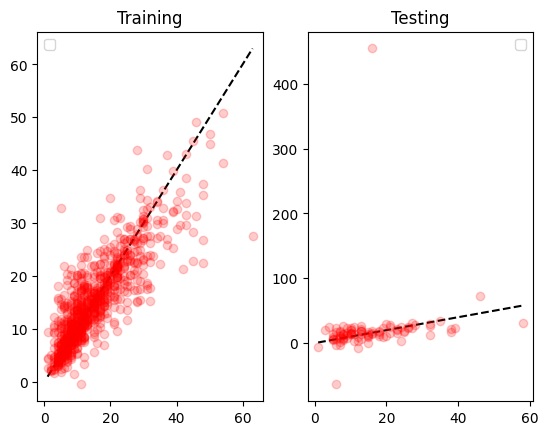

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 306.1538 - root_mean_squared_error: 17.4973 - val_loss: 308.5490 - val_root_mean_squared_error: 17.5656
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 283.2520 - root_mean_squared_error: 16.8301 - val_loss: 285.8379 - val_root_mean_squared_error: 16.9067
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 264.4079 - root_mean_squared_error: 16.2606 - val_loss: 266.3893 - val_root_mean_squared_error: 16.3214
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 246.8219 - root_mean_squared_error: 15.7106 - val_loss: 248.9700 - val_root_mean_squared_error: 15.7788
Epoch 5/50
27/27 [==============================] - 0s 2ms/step - loss: 230.6314 - root_mean_squared_error: 15.1866 - val_loss: 232.1728 - val_root_mean_squared_error: 15.2372
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 215.6521 - root_mean_squared_error: 14.6851 - va

Epoch 48/50
27/27 [==============================] - 0s 2ms/step - loss: 56.6860 - root_mean_squared_error: 7.5290 - val_loss: 77.1618 - val_root_mean_squared_error: 8.7842
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 55.7622 - root_mean_squared_error: 7.4674 - val_loss: 77.0141 - val_root_mean_squared_error: 8.7758
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 55.2745 - root_mean_squared_error: 7.4347 - val_loss: 76.1981 - val_root_mean_squared_error: 8.7292
linear train
6.382831616061268
linear_validation
8.316456497837523


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.847043457561568
FCM val RMSE: 144.3348695310748


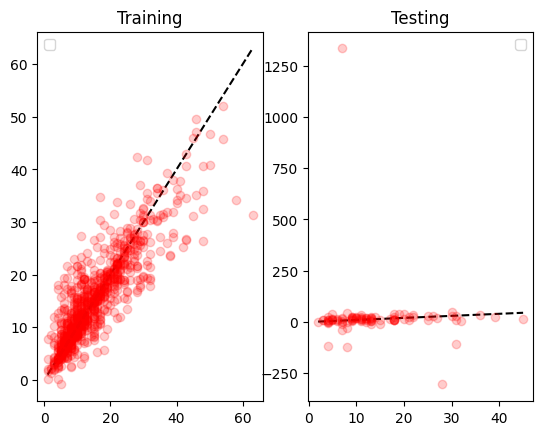

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 317.0796 - root_mean_squared_error: 17.8067 - val_loss: 252.0762 - val_root_mean_squared_error: 15.8769
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 291.4704 - root_mean_squared_error: 17.0725 - val_loss: 235.9019 - val_root_mean_squared_error: 15.3591
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 272.4195 - root_mean_squared_error: 16.5051 - val_loss: 219.5103 - val_root_mean_squared_error: 14.8159
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 254.0833 - root_mean_squared_error: 15.9400 - val_loss: 204.2176 - val_root_mean_squared_error: 14.2905
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 235.6969 - root_mean_squared_error: 15.3524 - val_loss: 189.6760 - val_root_mean_squared_error: 13.7723
Epoch 6/50
27/27 [==============================] - 0s 3ms/step - loss: 219.8188 - root_mean_squared_error: 14.8263 - va

27/27 [==============================] - 0s 2ms/step - loss: 53.1123 - root_mean_squared_error: 7.2878 - val_loss: 64.7185 - val_root_mean_squared_error: 8.0448
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 52.4872 - root_mean_squared_error: 7.2448 - val_loss: 65.0506 - val_root_mean_squared_error: 8.0654
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 52.0534 - root_mean_squared_error: 7.2148 - val_loss: 63.4680 - val_root_mean_squared_error: 7.9667
linear train
6.409509024863691
linear_validation
15580744159603.48


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.229134424653264
FCM val RMSE: 124.64758774892387


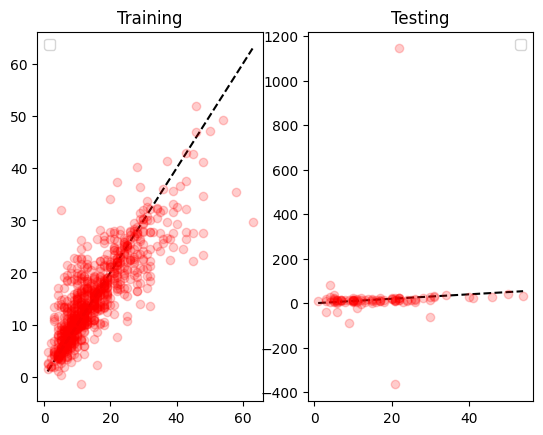

Epoch 1/50
27/27 [==============================] - 0s 5ms/step - loss: 309.4761 - root_mean_squared_error: 17.5919 - val_loss: 357.7957 - val_root_mean_squared_error: 18.9155
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 290.2500 - root_mean_squared_error: 17.0367 - val_loss: 342.2775 - val_root_mean_squared_error: 18.5007
Epoch 3/50
27/27 [==============================] - 0s 3ms/step - loss: 273.0683 - root_mean_squared_error: 16.5248 - val_loss: 324.3554 - val_root_mean_squared_error: 18.0099
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 255.9116 - root_mean_squared_error: 15.9972 - val_loss: 306.8146 - val_root_mean_squared_error: 17.5161
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 239.2286 - root_mean_squared_error: 15.4670 - val_loss: 290.0871 - val_root_mean_squared_error: 17.0319
Epoch 6/50
27/27 [==============================] - 0s 2ms/step - loss: 223.0483 - root_mean_squared_error: 14.9348 - va

Epoch 48/50
27/27 [==============================] - 0s 2ms/step - loss: 59.8187 - root_mean_squared_error: 7.7343 - val_loss: 95.3484 - val_root_mean_squared_error: 9.7647
Epoch 49/50
27/27 [==============================] - 0s 2ms/step - loss: 59.0580 - root_mean_squared_error: 7.6849 - val_loss: 93.2326 - val_root_mean_squared_error: 9.6557
Epoch 50/50
27/27 [==============================] - 0s 2ms/step - loss: 58.4355 - root_mean_squared_error: 7.6443 - val_loss: 93.5541 - val_root_mean_squared_error: 9.6723
target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 5
target RED EARTH has neightbour_stations 2 not match number_of_neighbours 5
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 5
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 5
target SLAVE LAKE has neightbour_stations 4 not match number_of_neighbours 5
target LLOYDMINSTER has neightbour_stations 3 not match number_of_neighbours 5
t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 1.2171670629355417e-07
FCM val RMSE: 280.3834102698471


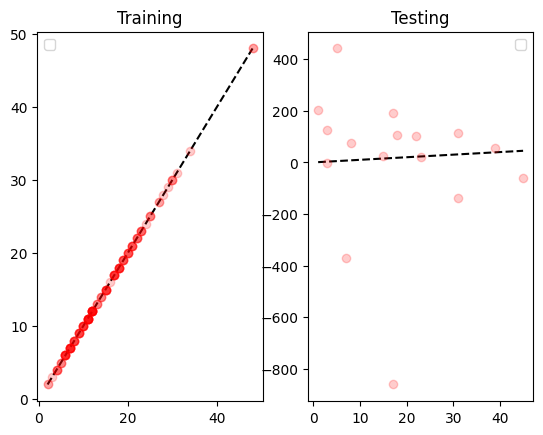

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 278.1670 - root_mean_squared_error: 16.6783 - val_loss: 482.8264 - val_root_mean_squared_error: 21.9733
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 269.0165 - root_mean_squared_error: 16.4017 - val_loss: 472.7357 - val_root_mean_squared_error: 21.7425
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 261.5342 - root_mean_squared_error: 16.1720 - val_loss: 463.1603 - val_root_mean_squared_error: 21.5212
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 255.7878 - root_mean_squared_error: 15.9934 - val_loss: 454.2791 - val_root_mean_squared_error: 21.3138
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 250.5827 - root_mean_squared_error: 15.8298 - val_loss: 445.5649 - val_root_mean_squared_error: 21.1084
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 245.9179 - root_mean_squared_error: 15.6818 - val_loss: 437

Epoch 48/50
5/5 [==============================] - 0s 5ms/step - loss: 129.1956 - root_mean_squared_error: 11.3664 - val_loss: 266.7067 - val_root_mean_squared_error: 16.3312
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - loss: 127.7228 - root_mean_squared_error: 11.3014 - val_loss: 263.9685 - val_root_mean_squared_error: 16.2471
Epoch 50/50
5/5 [==============================] - 0s 5ms/step - loss: 126.0862 - root_mean_squared_error: 11.2288 - val_loss: 261.5748 - val_root_mean_squared_error: 16.1733
linear train
4.4671452612017015
linear_validation
6269655792249.833


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 3.708882319826967e-07
FCM val RMSE: 2097.2558873323387


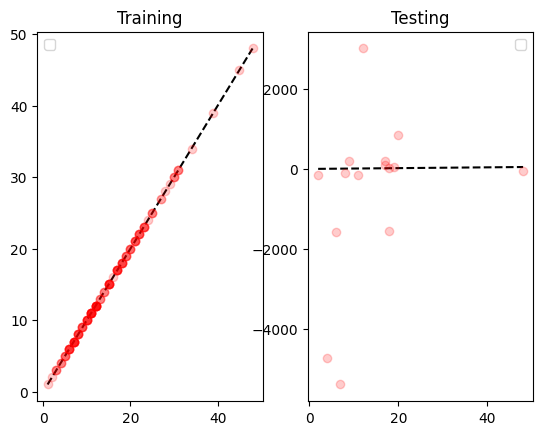

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 296.2954 - root_mean_squared_error: 17.2132 - val_loss: 309.6515 - val_root_mean_squared_error: 17.5969
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 286.3221 - root_mean_squared_error: 16.9211 - val_loss: 303.7730 - val_root_mean_squared_error: 17.4291
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 279.3722 - root_mean_squared_error: 16.7144 - val_loss: 298.1625 - val_root_mean_squared_error: 17.2674
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 273.4633 - root_mean_squared_error: 16.5367 - val_loss: 293.7890 - val_root_mean_squared_error: 17.1403
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 267.8600 - root_mean_squared_error: 16.3664 - val_loss: 290.6228 - val_root_mean_squared_error: 17.0477
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 262.8257 - root_mean_squared_error: 16.2119 - val_loss: 287

Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 141.8831 - root_mean_squared_error: 11.9115 - val_loss: 173.7515 - val_root_mean_squared_error: 13.1815
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - loss: 140.1756 - root_mean_squared_error: 11.8396 - val_loss: 172.1334 - val_root_mean_squared_error: 13.1200
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 138.3996 - root_mean_squared_error: 11.7643 - val_loss: 170.0610 - val_root_mean_squared_error: 13.0407
linear train
4.555225684545048
linear_validation
2390548623269.1074


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 1.1076103988467548e-05
FCM val RMSE: 13932.947671303664


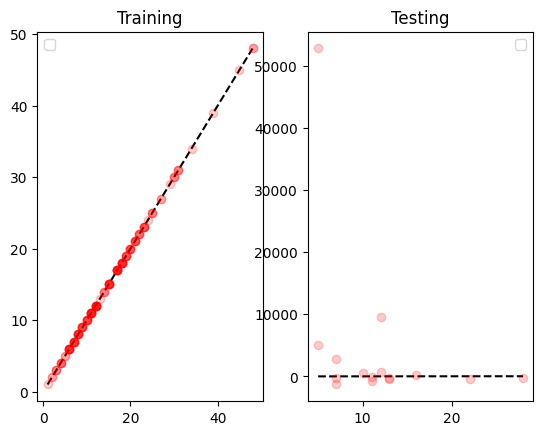

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 308.9276 - root_mean_squared_error: 17.5763 - val_loss: 171.9590 - val_root_mean_squared_error: 13.1133
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 299.9565 - root_mean_squared_error: 17.3193 - val_loss: 165.1302 - val_root_mean_squared_error: 12.8503
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 292.6393 - root_mean_squared_error: 17.1067 - val_loss: 159.7305 - val_root_mean_squared_error: 12.6385
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 287.1945 - root_mean_squared_error: 16.9468 - val_loss: 154.9660 - val_root_mean_squared_error: 12.4485
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 281.3923 - root_mean_squared_error: 16.7748 - val_loss: 151.2852 - val_root_mean_squared_error: 12.2998
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 276.3245 - root_mean_squared_error: 16.6230 - val_loss: 147

5/5 [==============================] - 0s 7ms/step - loss: 155.7348 - root_mean_squared_error: 12.4794 - val_loss: 85.8893 - val_root_mean_squared_error: 9.2676
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - loss: 154.1774 - root_mean_squared_error: 12.4168 - val_loss: 85.3465 - val_root_mean_squared_error: 9.2383
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 152.7521 - root_mean_squared_error: 12.3593 - val_loss: 84.5955 - val_root_mean_squared_error: 9.1976
linear train
4.430341891745341
linear_validation
1206150433477.5203


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.0973335491670545e-09
FCM val RMSE: 270.36145325454845


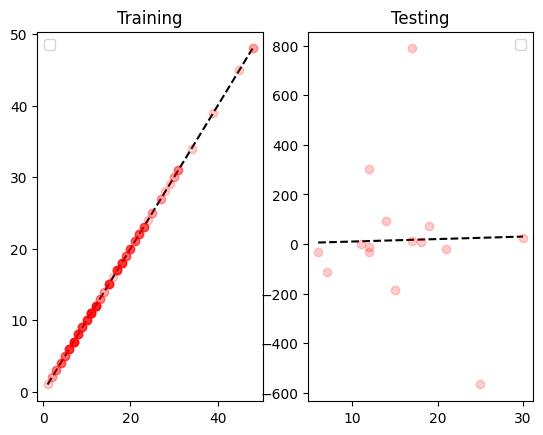

Epoch 1/50
5/5 [==============================] - 1s 147ms/step - loss: 300.4892 - root_mean_squared_error: 17.3346 - val_loss: 274.6485 - val_root_mean_squared_error: 16.5725
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 290.5464 - root_mean_squared_error: 17.0454 - val_loss: 267.0826 - val_root_mean_squared_error: 16.3427
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 284.2149 - root_mean_squared_error: 16.8587 - val_loss: 260.5170 - val_root_mean_squared_error: 16.1405
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 278.1313 - root_mean_squared_error: 16.6773 - val_loss: 255.3960 - val_root_mean_squared_error: 15.9811
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 273.6968 - root_mean_squared_error: 16.5438 - val_loss: 250.8053 - val_root_mean_squared_error: 15.8368
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 268.3677 - root_mean_squared_error: 16.3819 - val_loss: 24

Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 142.2438 - root_mean_squared_error: 11.9266 - val_loss: 149.9239 - val_root_mean_squared_error: 12.2443
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - loss: 140.5741 - root_mean_squared_error: 11.8564 - val_loss: 148.8630 - val_root_mean_squared_error: 12.2009
Epoch 50/50
5/5 [==============================] - 0s 5ms/step - loss: 138.8659 - root_mean_squared_error: 11.7841 - val_loss: 147.9671 - val_root_mean_squared_error: 12.1642
linear train
4.65864956374953
linear_validation
203660137298055.78


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.670255255164812e-08
FCM val RMSE: 6533.902234911533


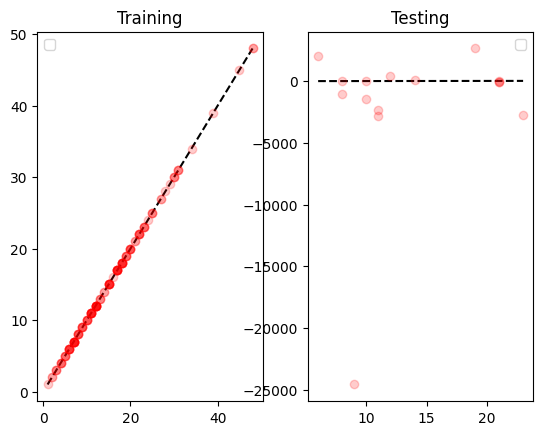

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 305.7642 - root_mean_squared_error: 17.4861 - val_loss: 220.4802 - val_root_mean_squared_error: 14.8486
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 296.6826 - root_mean_squared_error: 17.2245 - val_loss: 219.2470 - val_root_mean_squared_error: 14.8070
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 290.1643 - root_mean_squared_error: 17.0342 - val_loss: 217.9270 - val_root_mean_squared_error: 14.7624
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 284.2366 - root_mean_squared_error: 16.8593 - val_loss: 216.1784 - val_root_mean_squared_error: 14.7030
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 277.9117 - root_mean_squared_error: 16.6707 - val_loss: 214.1163 - val_root_mean_squared_error: 14.6327
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 273.1987 - root_mean_squared_error: 16.5287 - val_loss: 212

Epoch 48/50
5/5 [==============================] - 0s 7ms/step - loss: 149.3904 - root_mean_squared_error: 12.2225 - val_loss: 108.6346 - val_root_mean_squared_error: 10.4228
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 147.4718 - root_mean_squared_error: 12.1438 - val_loss: 107.3886 - val_root_mean_squared_error: 10.3628
Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 145.7210 - root_mean_squared_error: 12.0715 - val_loss: 106.2193 - val_root_mean_squared_error: 10.3063
linear train
3.351828068881694
linear_validation
88788089214.69054


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.180121496537864e-08
FCM val RMSE: 677.9408207692304


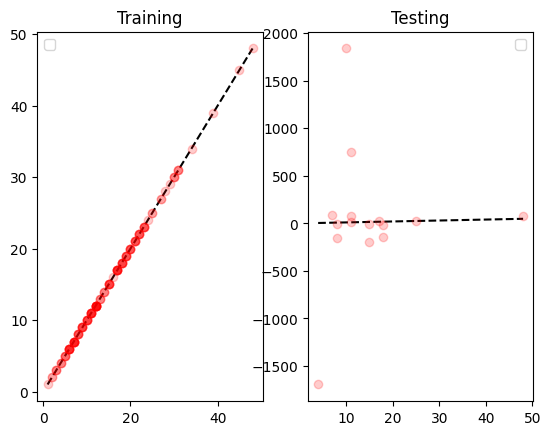

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 290.9090 - root_mean_squared_error: 17.0561 - val_loss: 303.6776 - val_root_mean_squared_error: 17.4263
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 281.5622 - root_mean_squared_error: 16.7798 - val_loss: 290.1216 - val_root_mean_squared_error: 17.0330
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 274.6735 - root_mean_squared_error: 16.5733 - val_loss: 278.0206 - val_root_mean_squared_error: 16.6739
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 268.8977 - root_mean_squared_error: 16.3981 - val_loss: 267.2762 - val_root_mean_squared_error: 16.3486
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 263.0306 - root_mean_squared_error: 16.2182 - val_loss: 259.3028 - val_root_mean_squared_error: 16.1029
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 258.6465 - root_mean_squared_error: 16.0825 - val_loss: 252

Epoch 48/50
5/5 [==============================] - 0s 7ms/step - loss: 144.8017 - root_mean_squared_error: 12.0334 - val_loss: 159.1331 - val_root_mean_squared_error: 12.6148
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 143.5497 - root_mean_squared_error: 11.9812 - val_loss: 158.2108 - val_root_mean_squared_error: 12.5782
Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 142.3233 - root_mean_squared_error: 11.9299 - val_loss: 157.3845 - val_root_mean_squared_error: 12.5453
linear train
4.263549592626891
linear_validation
38.05703080334861


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 1.9915448897499786e-06
FCM val RMSE: 1949.8698139407584


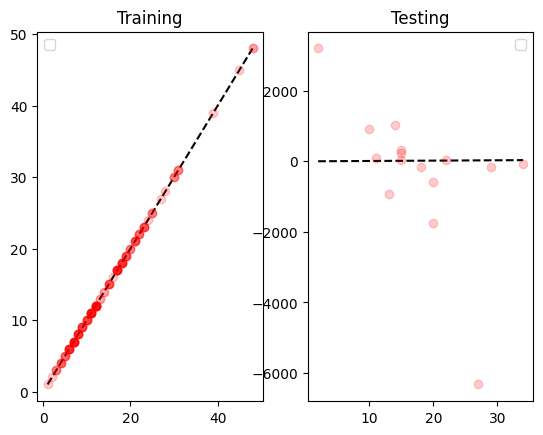

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 289.6641 - root_mean_squared_error: 17.0195 - val_loss: 367.9741 - val_root_mean_squared_error: 19.1827
Epoch 2/50
5/5 [==============================] - 0s 9ms/step - loss: 280.8660 - root_mean_squared_error: 16.7591 - val_loss: 359.4977 - val_root_mean_squared_error: 18.9604
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 273.1362 - root_mean_squared_error: 16.5268 - val_loss: 352.9423 - val_root_mean_squared_error: 18.7868
Epoch 4/50
5/5 [==============================] - 0s 8ms/step - loss: 268.0461 - root_mean_squared_error: 16.3721 - val_loss: 347.0567 - val_root_mean_squared_error: 18.6295
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 262.5670 - root_mean_squared_error: 16.2039 - val_loss: 342.0070 - val_root_mean_squared_error: 18.4934
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 258.0571 - root_mean_squared_error: 16.0642 - val_loss: 337

Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 138.6195 - root_mean_squared_error: 11.7737 - val_loss: 184.8402 - val_root_mean_squared_error: 13.5956
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 137.0130 - root_mean_squared_error: 11.7053 - val_loss: 182.3139 - val_root_mean_squared_error: 13.5024
Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 135.4491 - root_mean_squared_error: 11.6383 - val_loss: 180.0379 - val_root_mean_squared_error: 13.4178
linear train
4.317723695344563
linear_validation
1328182870169.5762


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 1.3179967661820077e-08
FCM val RMSE: 587.1468233630927


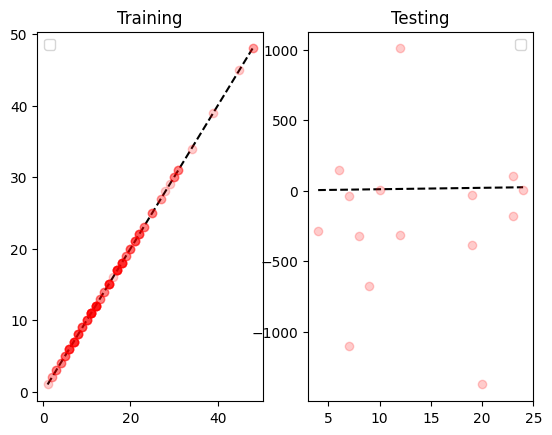

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 307.1208 - root_mean_squared_error: 17.5249 - val_loss: 235.4149 - val_root_mean_squared_error: 15.3432
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 297.0841 - root_mean_squared_error: 17.2361 - val_loss: 235.9845 - val_root_mean_squared_error: 15.3618
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 289.4935 - root_mean_squared_error: 17.0145 - val_loss: 235.4444 - val_root_mean_squared_error: 15.3442
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 283.0572 - root_mean_squared_error: 16.8243 - val_loss: 233.6033 - val_root_mean_squared_error: 15.2841
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 277.3179 - root_mean_squared_error: 16.6529 - val_loss: 232.0578 - val_root_mean_squared_error: 15.2334
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 272.2526 - root_mean_squared_error: 16.5001 - val_loss: 230

Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 144.7899 - root_mean_squared_error: 12.0329 - val_loss: 126.5946 - val_root_mean_squared_error: 11.2514
Epoch 49/50
5/5 [==============================] - 0s 7ms/step - loss: 143.0756 - root_mean_squared_error: 11.9614 - val_loss: 125.5924 - val_root_mean_squared_error: 11.2068
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 141.4766 - root_mean_squared_error: 11.8944 - val_loss: 125.0895 - val_root_mean_squared_error: 11.1843
linear train
4.223030261560933
linear_validation
39.218213317996415


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 4.2691377897809783e-10
FCM val RMSE: 113.54291207375076


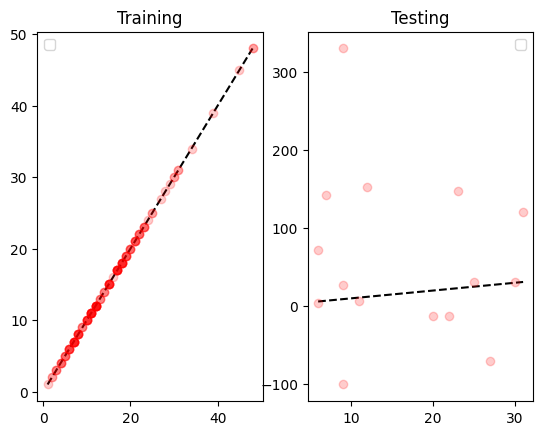

Epoch 1/50
5/5 [==============================] - 0s 22ms/step - loss: 293.2338 - root_mean_squared_error: 17.1241 - val_loss: 327.3161 - val_root_mean_squared_error: 18.0919
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 284.2952 - root_mean_squared_error: 16.8611 - val_loss: 315.9062 - val_root_mean_squared_error: 17.7737
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 276.6531 - root_mean_squared_error: 16.6329 - val_loss: 307.6285 - val_root_mean_squared_error: 17.5393
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 270.8327 - root_mean_squared_error: 16.4570 - val_loss: 300.8671 - val_root_mean_squared_error: 17.3455
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 265.4466 - root_mean_squared_error: 16.2925 - val_loss: 293.2533 - val_root_mean_squared_error: 17.1246
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 260.3453 - root_mean_squared_error: 16.1352 - val_loss: 286

Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 144.8806 - root_mean_squared_error: 12.0366 - val_loss: 133.9922 - val_root_mean_squared_error: 11.5755
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - loss: 143.5222 - root_mean_squared_error: 11.9801 - val_loss: 132.0747 - val_root_mean_squared_error: 11.4924
Epoch 50/50
5/5 [==============================] - 0s 6ms/step - loss: 142.0100 - root_mean_squared_error: 11.9168 - val_loss: 130.3311 - val_root_mean_squared_error: 11.4163
linear train
4.1054732998410906
linear_validation
12.403006279566227


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 2.6638530097274528e-08
FCM val RMSE: 291.61733607193565


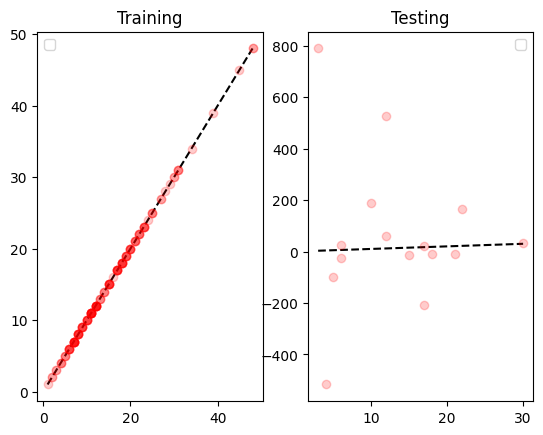

Epoch 1/50
5/5 [==============================] - 0s 21ms/step - loss: 306.6873 - root_mean_squared_error: 17.5125 - val_loss: 219.8822 - val_root_mean_squared_error: 14.8284
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 295.6404 - root_mean_squared_error: 17.1942 - val_loss: 210.2383 - val_root_mean_squared_error: 14.4996
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 288.0372 - root_mean_squared_error: 16.9717 - val_loss: 202.8656 - val_root_mean_squared_error: 14.2431
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 280.3167 - root_mean_squared_error: 16.7427 - val_loss: 198.2982 - val_root_mean_squared_error: 14.0818
Epoch 5/50
5/5 [==============================] - 0s 8ms/step - loss: 275.9024 - root_mean_squared_error: 16.6103 - val_loss: 194.0261 - val_root_mean_squared_error: 13.9293
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 271.2227 - root_mean_squared_error: 16.4688 - val_loss: 190

Epoch 48/50
5/5 [==============================] - 0s 6ms/step - loss: 155.3143 - root_mean_squared_error: 12.4625 - val_loss: 111.6494 - val_root_mean_squared_error: 10.5664
Epoch 49/50
5/5 [==============================] - 0s 6ms/step - loss: 153.6534 - root_mean_squared_error: 12.3957 - val_loss: 110.4439 - val_root_mean_squared_error: 10.5092
Epoch 50/50
5/5 [==============================] - 0s 7ms/step - loss: 152.0223 - root_mean_squared_error: 12.3297 - val_loss: 109.1913 - val_root_mean_squared_error: 10.4495
target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 6
target RED EARTH has neightbour_stations 2 not match number_of_neighbours 6
target MEDICINE HAT has neightbour_stations 5 not match number_of_neighbours 6
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 6
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 6
target SLAVE LAKE has neightbour_stations 4 not match number_of_neighbou

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 0.0006500008290750045
FCM val RMSE: 17.638084702861242


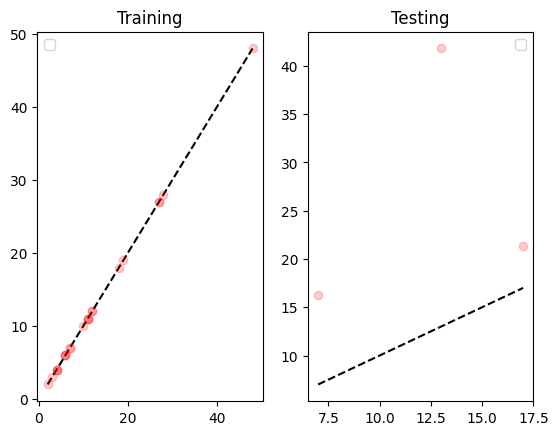

Epoch 1/50
1/1 [==============================] - 0s 226ms/step - loss: 274.1426 - root_mean_squared_error: 16.5573 - val_loss: 137.4786 - val_root_mean_squared_error: 11.7251
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 270.8374 - root_mean_squared_error: 16.4571 - val_loss: 133.8054 - val_root_mean_squared_error: 11.5674
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 267.6716 - root_mean_squared_error: 16.3607 - val_loss: 130.2623 - val_root_mean_squared_error: 11.4132
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 264.6536 - root_mean_squared_error: 16.2682 - val_loss: 126.8501 - val_root_mean_squared_error: 11.2628
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 261.7709 - root_mean_squared_error: 16.1793 - val_loss: 123.5733 - val_root_mean_squared_error: 11.1164
Epoch 6/50
1/1 [==============================] - 0s 22ms/step - loss: 259.0289 - root_mean_squared_error: 16.0944 - val_los

Epoch 48/50
1/1 [==============================] - 0s 22ms/step - loss: 192.1144 - root_mean_squared_error: 13.8605 - val_loss: 68.7726 - val_root_mean_squared_error: 8.2929
Epoch 49/50
1/1 [==============================] - 0s 22ms/step - loss: 191.1289 - root_mean_squared_error: 13.8249 - val_loss: 68.3166 - val_root_mean_squared_error: 8.2654
Epoch 50/50
1/1 [==============================] - 0s 22ms/step - loss: 190.1642 - root_mean_squared_error: 13.7900 - val_loss: 67.8592 - val_root_mean_squared_error: 8.2377
linear train
1.7431433611885864e-14
linear_validation
12.127330778864904


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 0.0014951399377377246
FCM val RMSE: 13.66928850710245


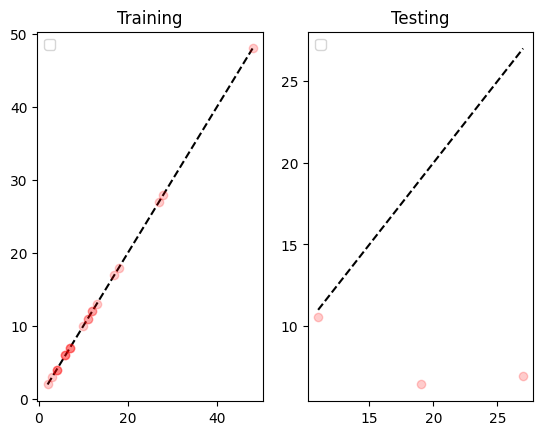

Epoch 1/50
1/1 [==============================] - 0s 225ms/step - loss: 250.2223 - root_mean_squared_error: 15.8184 - val_loss: 406.1066 - val_root_mean_squared_error: 20.1521
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 247.0005 - root_mean_squared_error: 15.7162 - val_loss: 403.7424 - val_root_mean_squared_error: 20.0933
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 243.9083 - root_mean_squared_error: 15.6176 - val_loss: 401.4154 - val_root_mean_squared_error: 20.0354
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 240.9465 - root_mean_squared_error: 15.5225 - val_loss: 399.1329 - val_root_mean_squared_error: 19.9783
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 238.1144 - root_mean_squared_error: 15.4310 - val_loss: 396.8889 - val_root_mean_squared_error: 19.9221
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 235.4108 - root_mean_squared_error: 15.3431 - val_los

1/1 [==============================] - 0s 23ms/step - loss: 178.4033 - root_mean_squared_error: 13.3568 - val_loss: 301.5625 - val_root_mean_squared_error: 17.3656
Epoch 48/50
1/1 [==============================] - 0s 20ms/step - loss: 177.5306 - root_mean_squared_error: 13.3241 - val_loss: 299.0658 - val_root_mean_squared_error: 17.2935
Epoch 49/50
1/1 [==============================] - 0s 22ms/step - loss: 176.6690 - root_mean_squared_error: 13.2917 - val_loss: 296.5924 - val_root_mean_squared_error: 17.2219
Epoch 50/50
1/1 [==============================] - 0s 22ms/step - loss: 175.8189 - root_mean_squared_error: 13.2597 - val_loss: 294.1454 - val_root_mean_squared_error: 17.1507
linear train
3.1056239768753526e-14
linear_validation
5.491158716748385


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 0.0023124993494639205
FCM val RMSE: 7.215358613011625


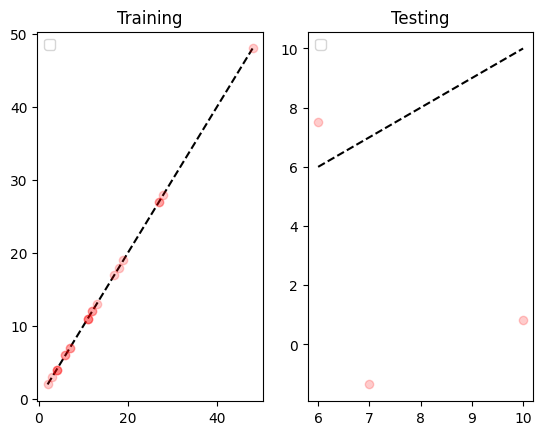

Epoch 1/50
1/1 [==============================] - 0s 236ms/step - loss: 312.9500 - root_mean_squared_error: 17.6904 - val_loss: 44.2457 - val_root_mean_squared_error: 6.6517
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 309.0453 - root_mean_squared_error: 17.5797 - val_loss: 46.7520 - val_root_mean_squared_error: 6.8375
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 305.2390 - root_mean_squared_error: 17.4711 - val_loss: 49.3787 - val_root_mean_squared_error: 7.0270
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 301.5375 - root_mean_squared_error: 17.3648 - val_loss: 52.1284 - val_root_mean_squared_error: 7.2200
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 297.9468 - root_mean_squared_error: 17.2611 - val_loss: 54.9998 - val_root_mean_squared_error: 7.4162
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 294.4685 - root_mean_squared_error: 17.1601 - val_loss: 57.9877

Epoch 48/50
1/1 [==============================] - 0s 21ms/step - loss: 210.4722 - root_mean_squared_error: 14.5077 - val_loss: 125.2756 - val_root_mean_squared_error: 11.1927
Epoch 49/50
1/1 [==============================] - 0s 20ms/step - loss: 209.1752 - root_mean_squared_error: 14.4629 - val_loss: 125.3803 - val_root_mean_squared_error: 11.1973
Epoch 50/50
1/1 [==============================] - 0s 25ms/step - loss: 207.9018 - root_mean_squared_error: 14.4188 - val_loss: 125.4789 - val_root_mean_squared_error: 11.2017
linear train
1.4977428203592124e-14
linear_validation
27.36085106152923


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 0.00106284832904435
FCM val RMSE: 24.462797001926603


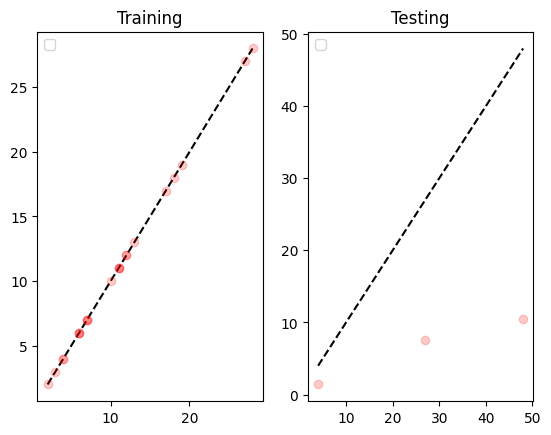

Epoch 1/50
1/1 [==============================] - 0s 226ms/step - loss: 165.7906 - root_mean_squared_error: 12.8760 - val_loss: 1048.0021 - val_root_mean_squared_error: 32.3729
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 163.0501 - root_mean_squared_error: 12.7691 - val_loss: 1039.8251 - val_root_mean_squared_error: 32.2463
Epoch 3/50
1/1 [==============================] - 0s 21ms/step - loss: 160.4330 - root_mean_squared_error: 12.6662 - val_loss: 1031.9520 - val_root_mean_squared_error: 32.1240
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 157.9344 - root_mean_squared_error: 12.5672 - val_loss: 1024.3550 - val_root_mean_squared_error: 32.0055
Epoch 5/50
1/1 [==============================] - 0s 21ms/step - loss: 155.5517 - root_mean_squared_error: 12.4720 - val_loss: 1017.0555 - val_root_mean_squared_error: 31.8913
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 153.2842 - root_mean_squared_error: 12.3808 - va

1/1 [==============================] - 0s 21ms/step - loss: 98.8785 - root_mean_squared_error: 9.9438 - val_loss: 892.4312 - val_root_mean_squared_error: 29.8736
Epoch 48/50
1/1 [==============================] - 0s 21ms/step - loss: 98.0031 - root_mean_squared_error: 9.8997 - val_loss: 890.0595 - val_root_mean_squared_error: 29.8339
Epoch 49/50
1/1 [==============================] - 0s 22ms/step - loss: 97.1445 - root_mean_squared_error: 9.8562 - val_loss: 887.6863 - val_root_mean_squared_error: 29.7941
Epoch 50/50
1/1 [==============================] - 0s 20ms/step - loss: 96.3038 - root_mean_squared_error: 9.8134 - val_loss: 885.3163 - val_root_mean_squared_error: 29.7543
linear train
1.6304788408914756e-14
linear_validation
20.607182321435886


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 5.036778653952837e-14
FCM val RMSE: 40.12088897143304


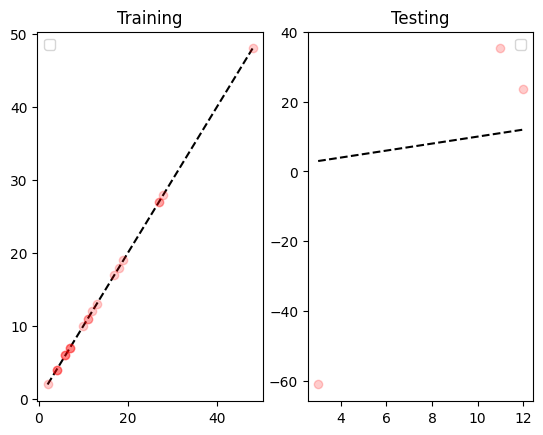

Epoch 1/50
1/1 [==============================] - 0s 226ms/step - loss: 299.0574 - root_mean_squared_error: 17.2933 - val_loss: 112.2562 - val_root_mean_squared_error: 10.5951
Epoch 2/50
1/1 [==============================] - 0s 22ms/step - loss: 295.7919 - root_mean_squared_error: 17.1986 - val_loss: 109.0302 - val_root_mean_squared_error: 10.4418
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 292.6026 - root_mean_squared_error: 17.1056 - val_loss: 105.8150 - val_root_mean_squared_error: 10.2866
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 289.5093 - root_mean_squared_error: 17.0150 - val_loss: 102.6085 - val_root_mean_squared_error: 10.1296
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 286.5133 - root_mean_squared_error: 16.9267 - val_loss: 99.4254 - val_root_mean_squared_error: 9.9712
Epoch 6/50
1/1 [==============================] - 0s 22ms/step - loss: 283.6158 - root_mean_squared_error: 16.8409 - val_loss:

1/1 [==============================] - 0s 22ms/step - loss: 214.6730 - root_mean_squared_error: 14.6517 - val_loss: 47.4043 - val_root_mean_squared_error: 6.8851
Epoch 49/50
1/1 [==============================] - 0s 22ms/step - loss: 213.6513 - root_mean_squared_error: 14.6168 - val_loss: 47.1602 - val_root_mean_squared_error: 6.8673
Epoch 50/50
1/1 [==============================] - 0s 21ms/step - loss: 212.6426 - root_mean_squared_error: 14.5823 - val_loss: 46.8910 - val_root_mean_squared_error: 6.8477
linear train
1.6739686760946102e-14
linear_validation
7.41353603193426


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 0.00036989304912926483
FCM val RMSE: 8.65691643274557


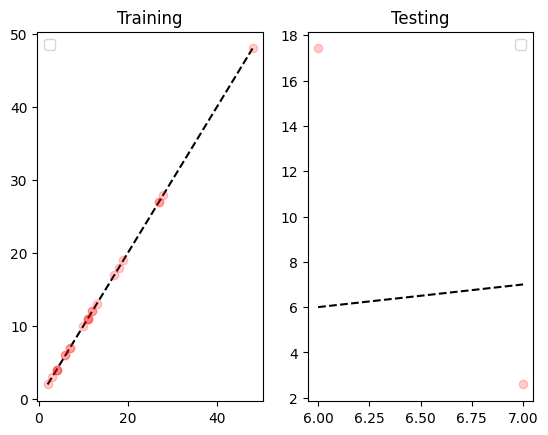

Epoch 1/50
1/1 [==============================] - 0s 236ms/step - loss: 292.4822 - root_mean_squared_error: 17.1021 - val_loss: 40.7984 - val_root_mean_squared_error: 6.3874
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 288.8572 - root_mean_squared_error: 16.9958 - val_loss: 42.3205 - val_root_mean_squared_error: 6.5054
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 285.3091 - root_mean_squared_error: 16.8911 - val_loss: 43.8649 - val_root_mean_squared_error: 6.6231
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 281.8378 - root_mean_squared_error: 16.7880 - val_loss: 45.4284 - val_root_mean_squared_error: 6.7401
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 278.4487 - root_mean_squared_error: 16.6868 - val_loss: 47.0013 - val_root_mean_squared_error: 6.8557
Epoch 6/50
1/1 [==============================] - 0s 21ms/step - loss: 275.1441 - root_mean_squared_error: 16.5875 - val_loss: 48.5781

1/1 [==============================] - 0s 22ms/step - loss: 198.7465 - root_mean_squared_error: 14.0977 - val_loss: 66.5711 - val_root_mean_squared_error: 8.1591
Epoch 49/50
1/1 [==============================] - 0s 21ms/step - loss: 197.6890 - root_mean_squared_error: 14.0602 - val_loss: 66.0492 - val_root_mean_squared_error: 8.1271
Epoch 50/50
1/1 [==============================] - 0s 20ms/step - loss: 196.6427 - root_mean_squared_error: 14.0229 - val_loss: 65.5257 - val_root_mean_squared_error: 8.0948
linear train
1.6103709138467164e-14
linear_validation
5.343390745234493


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 0.0004634406409441911
FCM val RMSE: 6.774035416067077


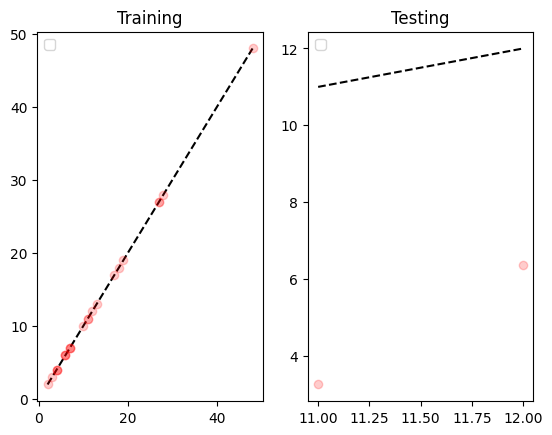

Epoch 1/50
1/1 [==============================] - 0s 229ms/step - loss: 279.0944 - root_mean_squared_error: 16.7061 - val_loss: 141.5736 - val_root_mean_squared_error: 11.8985
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 275.3846 - root_mean_squared_error: 16.5947 - val_loss: 139.3695 - val_root_mean_squared_error: 11.8055
Epoch 3/50
1/1 [==============================] - 0s 22ms/step - loss: 271.8327 - root_mean_squared_error: 16.4874 - val_loss: 137.1844 - val_root_mean_squared_error: 11.7126
Epoch 4/50
1/1 [==============================] - 0s 21ms/step - loss: 268.4403 - root_mean_squared_error: 16.3841 - val_loss: 135.0204 - val_root_mean_squared_error: 11.6198
Epoch 5/50
1/1 [==============================] - 0s 21ms/step - loss: 265.2051 - root_mean_squared_error: 16.2851 - val_loss: 132.8714 - val_root_mean_squared_error: 11.5270
Epoch 6/50
1/1 [==============================] - 0s 22ms/step - loss: 262.1250 - root_mean_squared_error: 16.1903 - val_los

Epoch 48/50
1/1 [==============================] - 0s 23ms/step - loss: 192.4892 - root_mean_squared_error: 13.8740 - val_loss: 48.4353 - val_root_mean_squared_error: 6.9595
Epoch 49/50
1/1 [==============================] - 0s 19ms/step - loss: 191.4214 - root_mean_squared_error: 13.8355 - val_loss: 47.3653 - val_root_mean_squared_error: 6.8822
Epoch 50/50
1/1 [==============================] - 0s 21ms/step - loss: 190.3713 - root_mean_squared_error: 13.7975 - val_loss: 46.3335 - val_root_mean_squared_error: 6.8069
linear train
1.6781637082355858e-14
linear_validation
5.065583091315923


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 3.4919033081832254e-14
FCM val RMSE: 6.456240865572567


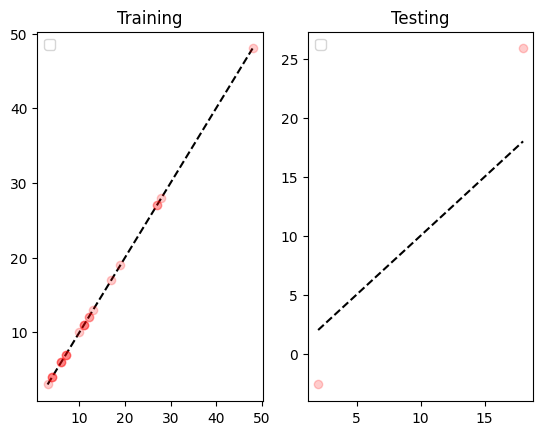

Epoch 1/50
1/1 [==============================] - 0s 229ms/step - loss: 281.0634 - root_mean_squared_error: 16.7649 - val_loss: 163.6395 - val_root_mean_squared_error: 12.7922
Epoch 2/50
1/1 [==============================] - 0s 24ms/step - loss: 277.6298 - root_mean_squared_error: 16.6622 - val_loss: 161.6052 - val_root_mean_squared_error: 12.7124
Epoch 3/50
1/1 [==============================] - 0s 24ms/step - loss: 274.3365 - root_mean_squared_error: 16.5631 - val_loss: 159.7210 - val_root_mean_squared_error: 12.6381
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 271.1895 - root_mean_squared_error: 16.4678 - val_loss: 157.9688 - val_root_mean_squared_error: 12.5686
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 268.1896 - root_mean_squared_error: 16.3765 - val_loss: 156.3357 - val_root_mean_squared_error: 12.5034
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 265.3309 - root_mean_squared_error: 16.2890 - val_los

1/1 [==============================] - 0s 23ms/step - loss: 192.4539 - root_mean_squared_error: 13.8728 - val_loss: 117.6946 - val_root_mean_squared_error: 10.8487
Epoch 48/50
1/1 [==============================] - 0s 22ms/step - loss: 191.1877 - root_mean_squared_error: 13.8271 - val_loss: 116.9896 - val_root_mean_squared_error: 10.8162
Epoch 49/50
1/1 [==============================] - 0s 23ms/step - loss: 189.9449 - root_mean_squared_error: 13.7820 - val_loss: 116.3002 - val_root_mean_squared_error: 10.7843
Epoch 50/50
1/1 [==============================] - 0s 22ms/step - loss: 188.7272 - root_mean_squared_error: 13.7378 - val_loss: 115.6268 - val_root_mean_squared_error: 10.7530
linear train
1.8622301511768148e-14
linear_validation
25.047106492913468


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 0.0012301316038113898
FCM val RMSE: 4.497962010969151


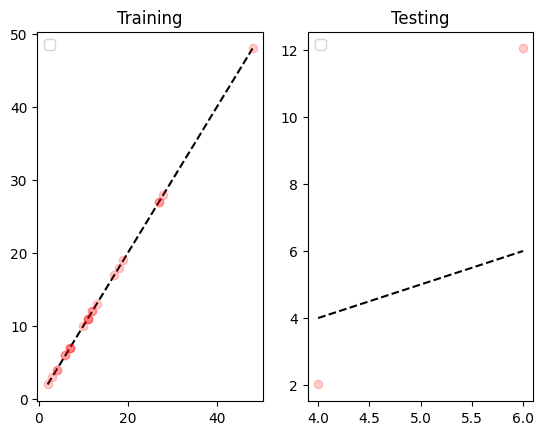

Epoch 1/50
1/1 [==============================] - 0s 224ms/step - loss: 298.0373 - root_mean_squared_error: 17.2638 - val_loss: 22.8975 - val_root_mean_squared_error: 4.7851
Epoch 2/50
1/1 [==============================] - 0s 27ms/step - loss: 294.0654 - root_mean_squared_error: 17.1483 - val_loss: 22.5997 - val_root_mean_squared_error: 4.7539
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 290.2209 - root_mean_squared_error: 17.0359 - val_loss: 22.4803 - val_root_mean_squared_error: 4.7413
Epoch 4/50
1/1 [==============================] - 0s 25ms/step - loss: 286.5112 - root_mean_squared_error: 16.9266 - val_loss: 22.5325 - val_root_mean_squared_error: 4.7468
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 282.9419 - root_mean_squared_error: 16.8209 - val_loss: 22.7495 - val_root_mean_squared_error: 4.7696
Epoch 6/50
1/1 [==============================] - 0s 21ms/step - loss: 279.5227 - root_mean_squared_error: 16.7189 - val_loss: 23.1232

1/1 [==============================] - 0s 23ms/step - loss: 202.5648 - root_mean_squared_error: 14.2325 - val_loss: 45.8466 - val_root_mean_squared_error: 6.7710
Epoch 49/50
1/1 [==============================] - 0s 23ms/step - loss: 201.3139 - root_mean_squared_error: 14.1885 - val_loss: 45.8450 - val_root_mean_squared_error: 6.7709
Epoch 50/50
1/1 [==============================] - 0s 22ms/step - loss: 200.0851 - root_mean_squared_error: 14.1451 - val_loss: 45.8618 - val_root_mean_squared_error: 6.7721
linear train
1.377081340934826e-14
linear_validation
21.30254737252753


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM traning RMSE: 2.5955485221023013e-14
FCM val RMSE: 22.514350301185825


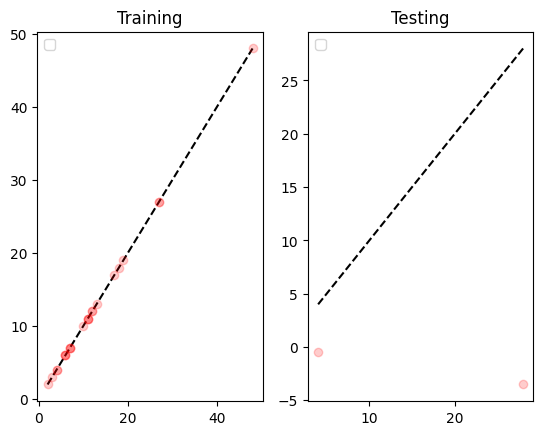

Epoch 1/50
1/1 [==============================] - 0s 223ms/step - loss: 266.8260 - root_mean_squared_error: 16.3348 - val_loss: 343.8087 - val_root_mean_squared_error: 18.5421
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 263.7518 - root_mean_squared_error: 16.2404 - val_loss: 338.5717 - val_root_mean_squared_error: 18.4003
Epoch 3/50
1/1 [==============================] - 0s 21ms/step - loss: 260.7889 - root_mean_squared_error: 16.1490 - val_loss: 333.5501 - val_root_mean_squared_error: 18.2634
Epoch 4/50
1/1 [==============================] - 0s 20ms/step - loss: 257.9375 - root_mean_squared_error: 16.0604 - val_loss: 328.7798 - val_root_mean_squared_error: 18.1323
Epoch 5/50
1/1 [==============================] - 0s 22ms/step - loss: 255.2013 - root_mean_squared_error: 15.9750 - val_loss: 324.2544 - val_root_mean_squared_error: 18.0071
Epoch 6/50
1/1 [==============================] - 0s 22ms/step - loss: 252.5700 - root_mean_squared_error: 15.8925 - val_los

1/1 [==============================] - 0s 22ms/step - loss: 183.8112 - root_mean_squared_error: 13.5577 - val_loss: 287.7512 - val_root_mean_squared_error: 16.9632
Epoch 48/50
1/1 [==============================] - 0s 21ms/step - loss: 182.6132 - root_mean_squared_error: 13.5134 - val_loss: 287.9568 - val_root_mean_squared_error: 16.9693
Epoch 49/50
1/1 [==============================] - 0s 24ms/step - loss: 181.4298 - root_mean_squared_error: 13.4696 - val_loss: 288.1363 - val_root_mean_squared_error: 16.9746
Epoch 50/50
1/1 [==============================] - 0s 21ms/step - loss: 180.2599 - root_mean_squared_error: 13.4261 - val_loss: 288.2879 - val_root_mean_squared_error: 16.9790


In [21]:
do_experiment(number_of_neighbour_stations)

In [22]:
training_results

[[{'linear_train': 6.700927612737708},
  {'fcm_train': 6.504994835101076},
  {'nn_train': 6.549590072631836},
  {'linear_train': 6.714233708158953},
  {'fcm_train': 6.517728331267349},
  {'nn_train': 6.526524333953858},
  {'linear_train': 6.704168197114038},
  {'fcm_train': 6.488666251244116},
  {'nn_train': 6.488602132797241},
  {'linear_train': 6.712786808989243},
  {'fcm_train': 6.497763337421879},
  {'nn_train': 6.508720855712891},
  {'linear_train': 6.698856321536942},
  {'fcm_train': 6.507521147557852},
  {'nn_train': 6.531105451583862},
  {'linear_train': 6.698395946008462},
  {'fcm_train': 6.4821783341429535},
  {'nn_train': 6.477829809188843},
  {'linear_train': 6.719099072374869},
  {'fcm_train': 6.522181111077609},
  {'nn_train': 6.559340515136719},
  {'linear_train': 6.70665689808311},
  {'fcm_train': 6.518110875475602},
  {'nn_train': 6.5396356105804445},
  {'linear_train': 6.71745185801283},
  {'fcm_train': 6.522769429412786},
  {'nn_train': 6.547456369400025},
  {'linear

In [49]:
for exp in validation_results :
    data = [d['nn_val'] for d in exp if 'nn_val' in d]
    print(f"{np.round(np.mean(data), 4)}±{np.round(np.std(data),4)}")
#     print(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
#     print(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

6.5449±0.0784
6.4866±0.1545
7.5929±0.2618
10.6299±0.9603
14.0571±2.1005
12.9026±7.0723


In [23]:
validation_results

[[{'linear_val': 7.252793776053193},
  {'fcm_val': 6.723743812004997},
  {'nn_val': 6.645024042129517},
  {'linear_val': 6.664847689997698},
  {'fcm_val': 6.471680624761969},
  {'nn_val': 6.3966539478302},
  {'linear_val': 6.756286092232229},
  {'fcm_val': 6.624269606924375},
  {'nn_val': 6.52428858757019},
  {'linear_val': 6.675519417318537},
  {'fcm_val': 6.678592690175989},
  {'nn_val': 6.5755962562561034},
  {'linear_val': 6.801773421500031},
  {'fcm_val': 6.668646428789935},
  {'nn_val': 6.633694143295288},
  {'linear_val': 6.812586555629654},
  {'fcm_val': 6.632788798514573},
  {'nn_val': 6.557865467071533},
  {'linear_val': 6.616486681702096},
  {'fcm_val': 6.4835239643623845},
  {'nn_val': 6.5924540138244625},
  {'linear_val': 6.733385654435337},
  {'fcm_val': 6.57289622277478},
  {'nn_val': 6.596965675354004},
  {'linear_val': 6.638614194784962},
  {'fcm_val': 6.525972781177942},
  {'nn_val': 6.433578310012817},
  {'linear_val': 6.726340363190308},
  {'fcm_val': 6.568864006837

Text(0.5, 1.0, 'RMSE wind speed vs number of stations for training dataset')

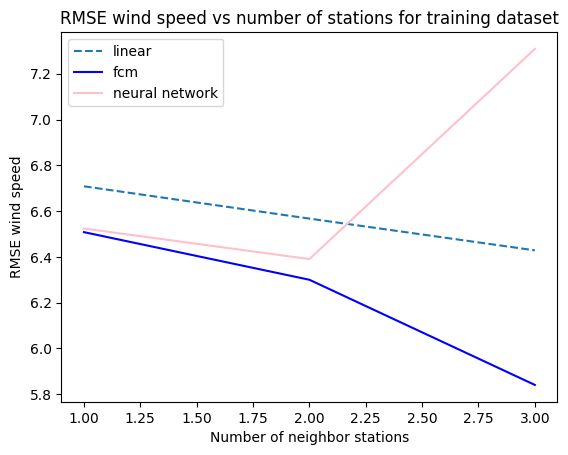

In [24]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = [1,2,3]#number_of_neighbour_stations
for exp in training_results:
    li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
    fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
    nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

plt.plot(x_axis, li_train_plot[0:3], '--', label='linear')
plt.plot(x_axis, fcm_train_plot[0:3], label='fcm', c='blue')
plt.plot(x_axis, nn_train_plot[0:3], label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Number of neighbor stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations for training dataset')

Text(0.5, 1.0, 'RMSE wind speed vs number of stations for validation dataset')

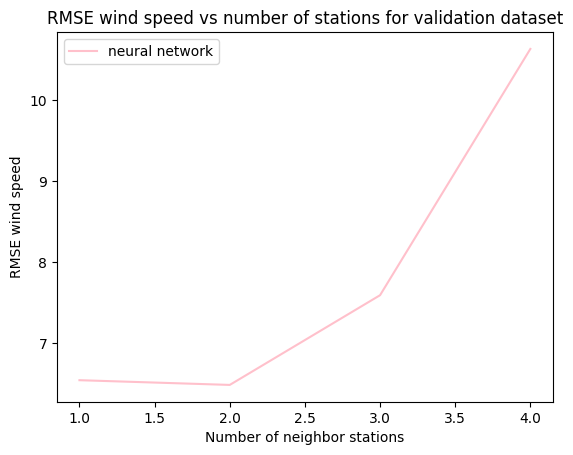

In [29]:

li_val_plot = []
fcm_val_plot = []
nn_val_plot = []
x_axis = [1,2,3,4]#number_of_neighbour_stations
for exp in validation_results:
    li_val_plot.append(np.mean([d['linear_val'] for d in exp if 'linear_val' in d]))
    fcm_val_plot.append(np.mean([d['fcm_val'] for d in exp if 'fcm_val' in d]))
    nn_val_plot.append(np.mean([d['nn_val'] for d in exp if 'nn_val' in d]))


#plt.plot(x_axis, li_val_plot, '--', label='linear')
#plt.plot(x_axis, fcm_val_plot[0:4], label='fcm', c='blue')
plt.plot(x_axis, nn_val_plot[0:4], label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(0,20)
plt.xlabel('Number of neighbor stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations for validation dataset')

Text(0.5, 1.0, 'Training and validation MSE for neural network model')

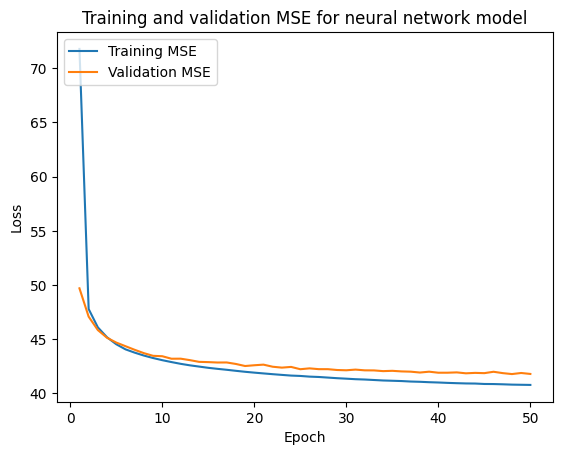

In [26]:
nn_histories

nn_val_plot = []
nn_train_plot = []
x_axis = range(1, number_of_epochs + 1)

exp = nn_histories[0]

nn_train_plot = [d['loss'] for d in exp if 'loss' in d]
nn_val_plot = [d['val_loss'] for d in exp if 'val_loss' in d]

plt.plot(x_axis, np.mean(nn_train_plot, axis=0), label='Training MSE')
plt.plot(x_axis, np.mean(nn_val_plot, axis=0), label='Validation MSE')
plt.legend(loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation MSE for neural network model')

In [67]:
# Results containers
out_of_box_training_results = []
out_of_box_test_results = []
out_of_box_nn_histories = []
out_of_box_nn_model

# Determine the optimal value for the given hyperparameter
def do_test(train_data, test_data):
    # First fitler the data based on the settings
    train_x = []
    train_y = []
    test_x = []
    test_y = []

    for station in train_data['name'].unique():
        features, target = Data_utils.generate_data(
            train_data, 
            station, 
            2, 
            max_threshold_distance, 
            min_threshold_distance
        )

        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            train_x.append(np_features)
            train_y.append(np_target)
    
    for station in train_data['name'].unique():
        features, target = Data_utils.generate_data(
            test_data, 
            station, 
            2, 
            max_threshold_distance, 
            min_threshold_distance
        )
        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            test_x.append(np_features)
            test_y.append(np_target)

    # After all stations are filtered, flatten the data into a huge list        
    train_x = np.array([data for sublist in train_x for data in sublist])
    train_y = np.array([data for sublist in train_y for data in sublist])
    train_x, train_y = shuffle(train_x, train_y)
    
    test_x = np.array([data for sublist in test_x for data in sublist])
    test_y = np.array([data for sublist in test_y for data in sublist])
    test_x, test_y = shuffle(test_x, test_y)
    
    np.savetxt("teacher_test_x.csv", test_x, delimiter=",")
    np.savetxt("teacher_test_y.csv", test_y, delimiter=",")

    # Normalize the input
    train_x, test_x = preprocess_data(train_x, test_x)            
    # Linear model
    li_train_rmse, li_test_rmse = linear_model(train_x, train_y, test_x, test_y)
    out_of_box_training_results.append({'linear_train' : li_train_rmse})
    out_of_box_test_results.append({'linear_test' : li_test_rmse})

    # FCM model
    fcm_train_rmse, fcm_test_rmse = fcm_rule_model(train_x, train_y, test_x, test_y)
    out_of_box_training_results.append({'fcm_train' : fcm_train_rmse})
    out_of_box_test_results.append({'fcm_test' : fcm_test_rmse})

    # NN
    nn_history, nn_train_rmse, nn_test_rmse, out_of_box_nn_model = neural_network_model(train_x, train_y, test_x, test_y)
    out_of_box_nn_histories.append(nn_history.history)
    out_of_box_training_results.append({'nn_train' : nn_train_rmse})
    out_of_box_test_results.append({'nn_test' : nn_test_rmse})
   
        
        

target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 2
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 2
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 2
target HIGH LEVEL has neightbour_stations 0 not match number_of_neighbours 2
target HIGH LEVEL A has neightbour_stations 0 not match number_of_neighbours 2
target FORT MCMURRAY CS has neightbour_stations 0 not match number_of_neighbours 2
target FORT MCMURRAY A has neightbour_stations 0 not match number_of_neighbours 2
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 2
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 2
target HIGH LEVEL has neightbour_stations 0 not match number_of_neighbours 2
target HIGH LEVEL A has neightbour_stations 0 not match number_of_neighbours 2
target FORT MCMURRAY CS has neightbour_stations 0 not match number_of_neighbours 2
linear train
6.56740730589

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.481582839099747
Epoch 1/50
723/723 [==============================] - 2s 2ms/step - loss: 143.4384 - root_mean_squared_error: 11.9766 - val_loss: 74.4492 - val_root_mean_squared_error: 8.6284
Epoch 2/50
723/723 [==============================] - 1s 2ms/step - loss: 63.8403 - root_mean_squared_error: 7.9900 - val_loss: 53.0277 - val_root_mean_squared_error: 7.2820
Epoch 3/50
723/723 [==============================] - 1s 2ms/step - loss: 50.5366 - root_mean_squared_error: 7.1089 - val_loss: 46.6320 - val_root_mean_squared_error: 6.8288
Epoch 4/50
723/723 [==============================] - 1s 2ms/step - loss: 46.1160 - root_mean_squared_error: 6.7909 - val_loss: 44.6584 - val_root_mean_squared_error: 6.6827
Epoch 5/50
723/723 [==============================] - 1s 2ms/step - loss: 44.0264 - root_mean_squared_error: 6.6352 - val_loss: 43.2433 - val_root_mean_squared_error: 6.5760
Epoch 6/50
723/723 [==============================] - 1s 2ms/step - loss: 42.7284 - root_mean_sq

Epoch 48/50
723/723 [==============================] - 1s 2ms/step - loss: 36.7153 - root_mean_squared_error: 6.0593 - val_loss: 39.3768 - val_root_mean_squared_error: 6.2751
Epoch 49/50
723/723 [==============================] - 1s 2ms/step - loss: 36.4949 - root_mean_squared_error: 6.0411 - val_loss: 39.8178 - val_root_mean_squared_error: 6.3101
Epoch 50/50
723/723 [==============================] - 1s 2ms/step - loss: 36.5415 - root_mean_squared_error: 6.0450 - val_loss: 39.6325 - val_root_mean_squared_error: 6.2954


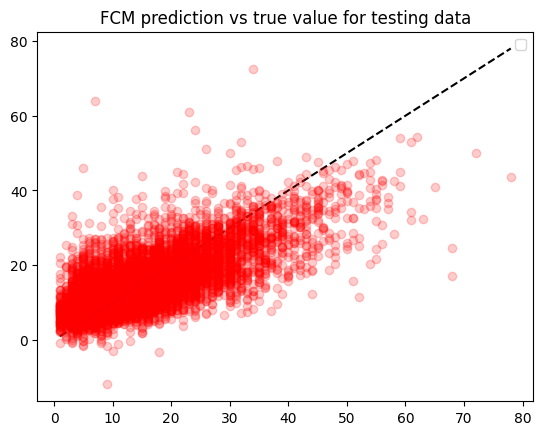

In [70]:
do_test(teacher_model_training_data, teacher_model_test_data)

In [62]:
out_of_box_nn_histories

[{'loss': [135.7477264404297,
   61.20619201660156,
   49.971031188964844,
   46.38515853881836,
   44.40057373046875,
   43.196224212646484,
   42.36191177368164,
   41.84012985229492,
   41.27787399291992,
   40.95476150512695,
   40.63440704345703,
   40.399436950683594,
   40.15083312988281,
   40.00099182128906,
   39.84886169433594,
   39.59422302246094,
   39.496036529541016,
   39.35190200805664,
   39.12342834472656,
   39.053043365478516,
   38.84136199951172,
   38.6950798034668,
   38.6190071105957,
   38.385948181152344,
   38.376277923583984,
   38.29365921020508,
   38.10679244995117,
   38.1117057800293,
   38.0345458984375,
   37.8314208984375,
   37.73664474487305,
   37.73688507080078,
   37.666969299316406,
   37.495384216308594,
   37.51496505737305,
   37.36476516723633,
   37.26976013183594,
   37.24116516113281,
   37.14035415649414,
   37.14543914794922,
   37.076324462890625,
   36.95697021484375,
   36.96982192993164,
   36.90302276611328,
   36.7650794982910

In [69]:
nn_prediction = out_of_box_nn_model.predict(test_x)

plt.plot([min(test_y),max(test_y)], [min(test_y),max(test_y)], 'k--')
plt.plot(test_y, nn_prediction, 'ro', alpha=.2)
plt.title('Testing')
plt.legend()
plt.show()

AttributeError: 'list' object has no attribute 'predict'